# Menu <a class="anchor" id="menu"></a>
* [1 Préparation du jeu de données](#models_prepare)
    * [1.1 Découpage du jeu de données](#models_prepare_split)
    * [1.2 Encodage des variables qualitatives](#models_prepare_encode)
    * [1.3 Imputation des valeurs manquantes](#models_prepare_impute)
    * [1.4 Normalisation](#models_prepare_normalize)
    * [1.5 Choix des outils de mesure](#models_prepare_metrics)
* [2. Algorithmes sans optimisation](#models)
    * [2.1 (Naïve) DummyClassifier](#models_dummy)
    * [2.2 (Linear) Logistic Regression](#models_linear)
    * [2.3 (Non-Linear) Decision Tree](#models_decision_tree)
    * [2.4 (Non-Linear) K-Nearest Neighbors](#models_knn)
    * [2.5 (Ensemble) Random Forest](#models_random_forest)
    * [2.6 (Ensemble) XGBoost](#models_xgboost)
* [3. Recherche des meilleurs paramètres avec `GreadSearchCV`](#models_grid)
    * [3.1 Logistic Regression Grid](#models_linear_grid)
    * [3.2 Decision Tree Grid](#models_decision_tree_grid)
    * [3.3 Random Forest Grid](#models_random_forest_grid)
    * [3.4 XGBoost Grid](#models_xgboost_grid)
* [4. Améliorer les modèles avec `class_weigth`](#models_balanced)
    * [4.1 Logistic Regression](#models_linear_balanced)
    * [4.2 Decision Tree](#models_decision_tree_balanced)
    * [4.3 Random Forest](#models_random_forest_balanced)
    * [4.4 XGBoost Classifier](#models_xgboost_balanced)
* [5. Améliorer les modèles avec `SMOT`](#models_smot)
    * [5.1 Logistic Regression](#models_linear_smot)
    * [5.2 Decision Tree](#models_decision_tree_smot)
    * [5.3 K-Nearest Neighbors](#models_knn_smot)
    * [5.3 Random Forest](#models_random_forest_smot)
    * [5.4 XGBoost Classifier](#models_xgboost_smot)
* [6. Améliorer les modèles avec de `nouvelles features`](#models_feature_engineering)
    * [6.0 Feature Engineering](#feature_engineering)
    * [6.1 Logistic Regression](#models_linear_balanced_feature)
    * [6.2 Decision Tree](#models_decision_tree_balanced_feature)
    * [6.3 Random Forest](#models_random_forest_balanced_feature)
    * [6.4 XGBoost Classifier](#models_xgboost_balanced_feature)

# Mise en place

### Chargeons les librairies utiles

In [1]:
import time
import copy as cp
from collections import defaultdict
from zipfile import ZipFile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

### Chargons le jeu de données

In [2]:
zip_file = ZipFile('data/Projet+Mise+en+prod+-+home-credit-default-risk.zip')

In [3]:
data_application_train = pd.read_csv(
    zip_file.open('application_train.csv'),
    #dtype=dtypes, 
    #usecols=cols_to_keep,
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

data_application_train.shape

(307511, 122)

### Faisons quelques réglages pour mieux voir les DataFrames pandas

In [4]:
pd.options.display.max_columns = data_application_train.shape[0]
pd.options.display.max_rows = 100

### Réduisons la taille du jeu de données pour les essais préliminaires des différents modèles

In [5]:
sample_size_base = 30000
sample_size_grid = 30000
data_work = data_application_train[:sample_size_base].copy()

# Préparons le jeu de données <a class="anchor" id="models_prepare"></a> [⇪](#menu)

### Découpage du jeu de données  <a class="anchor" id="models_prepare_split"></a> [⇪](#menu)

> Il existe au moins 2 approches pour le découpage du jeu de données.
> 1. On peut le découper en 3 sous-ensembles `Train`, `Validation` et `Test`.
> 2. On peut le découper en 2 sous-ensembles `Train` et `Test`.
>
> Idéalement, il nous faut idéalement les trois jeux de données:
> - Le `Train` set pour entrainer les différents modèles *(différents algorithmes ou paramètres)*.
> - Le `Validation` set pour choisir le modèle le plus performant sur des données non-vues lors de l'entrainement.
> - Le `Test` set pour estimer la généralisation du modèle choisi *(une fois ré-entrainé avec l'ensemble training+validation)*, et donc vérifier que les scores de validation ne sont pas des overfit ou underfit.
>
> Mais lorsque l'on utiliser une méthode de **cross-validation** comme le K-Fold ou le StratifiedKFold, on peut se contenter d'un découpage en 2 sous jeu de données, car le jeu d'entrainement est alors découper en k sections qui sont tour à tour utilisées en tant que set de `Validation` pour que les k-1 autres sections sont utilisées pour en tant que `Train` set *(ce qui permet d'utiliser une plus grande fraction des données pour l'entrainement final)*.
>
> Dans ce projet, il est utile (et demandé) de faire de la cross-validation, aussi allons nous utiliser un découpage en deux sous ensemble `Train` et `Test`.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_full = data_work.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_work['TARGET']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.15,
                                                random_state=0,
                                                stratify=Y_full)

In [9]:
print(f"X_train: {X_train.shape[0] / X_full.shape[0] * 100}% | X_test: {X_test.shape[0] / X_full.shape[0]* 100}%")

X_train: 85.0% | X_test: 15.0%


### Encodage des données non-numériques <a class="anchor" id="models_prepare_encode"></a> [⇪](#menu)
> Pour pouvoir travailler, les algorithmes ont besoin de données numériques. Il nous faut donc transformer celles qui ne le sont pas avant de pouvoir entrainer et évaluer des modèles.
>
> Il existe plusieurs approches comme le LabelEncoder, l'OrdinalEncoder ou encore le OneHotEncoder.
> - Le `LabelEncoder` est adapté pour transformer la variable cible tout en restant sur une seule colonne.
> - L'`OrdinalEncoder` est adapté pour transformer les features tout en restant sur une seule colonne.
> - Le `OneHotEncoder` est adapté pour transformer les features en valeurs binaires sur plusieurs colonnes.
>
> Pour les variables catégorielles où il n'existe pas de relation ordinale, l'`OrdinalEncoder` peut au mieux ne pas être suffisant, ou au pire induire le modèle en erreur. Dans ce cas, il convient d'utiliser le `OneHotEncoder`.
>
> Les variables qui pourraient être considérée comme ordindal d'après notre EDA sont:
> - `NAME_EDUCATION_TYPE`
> - `WEEKDAY_APPR_PROCESS_START`
>
> Nous allons donc appliquer un `OrdinalEncoder` sur ces deux variables et un `OneHotEncoder` sur le reste. La variable cible elle n'a pas besoin d'être encodée car ce sont déjà des 0 et des 1.

In [10]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder #, LabelEncoder

In [11]:
def fit_labels(data):
    """ Prepare the encoder for the categorical columns.
        
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset used as reference for the label encoders
        
    Returns
    -------
    OrdinalEncoder
        the OE instance used to encode columns with 2 unique values
    OneHotEncoder
        the OHE instance used to encode columns with 3+ unique values
    """
    
    # Define columns
    oe_targets = ['NAME_EDUCATION_TYPE', 'WEEKDAY_APPR_PROCESS_START']
    ohe_targets = [x for x in data.select_dtypes(exclude='number').columns if x not in oe_targets]
        
    # OrdinalEncoder
    oe = OrdinalEncoder()
    oe.fit(data[oe_targets])
    
    # OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[ohe_targets])
    
    return oe, ohe

def transform_labels(data, oe_model, ohe_mode):
    """ Transform the provided dataset using the provided encoders.
            
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset that needs to be label encoded
        
    Returns
    -------
    DataFrame
        a new dataframe with the encoded labels instead of the non encoded ones
    """
    dt = data.copy()
    
    # OrdinalEncoder
    dt[oe_model.feature_names_in_] = oe_model.transform(dt[oe_model.feature_names_in_])
    
    # OneHotEncoder
    array_hot_encoded = ohe_model.transform(dt[ohe_model.feature_names_in_])
    data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dt.index, columns=ohe_model.get_feature_names_out())
    data_other_cols = dt.drop(columns=ohe_model.feature_names_in_)
    dt = pd.concat([data_hot_encoded, data_other_cols], axis=1)
    
    return dt

#### On entraine les deux encoders sur le `train` set

In [12]:
oe_model, ohe_model = fit_labels(X_train)

#### On transforme les données des `training` et `testing` sets

In [13]:
X_train = transform_labels(X_train, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)

### Imputations des données manquantes <a class="anchor" id="models_prepare_impute"></a> [⇪](#menu)

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [15]:
def fit_imputer(data, columns):
    
    imputer = SimpleImputer(strategy='median')
    #imputer = IterativeImputer(
    #    imputation_order='ascending', 
    #    random_state=0, 
        #min_value=0, 
        #max_value=max_values_imput
    #    n_nearest_features = 10,
    #)
    imputer.fit(data[columns])
    
    return imputer

def impute(data, imputer):
    
    dt = data.copy()
    dt_imput = pd.DataFrame(imputer.transform(dt[imputer.feature_names_in_]), index=dt.index, columns=imputer.feature_names_in_)
    dt[imputer.feature_names_in_] = dt_imput
    print(dt.shape, type(dt))
    
    return dt

#### On entraine l'imputer sur le `train` set

In [16]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

#### On transforme les données des `training` et `testing` sets

In [17]:
X_train = impute(X_train, imputer_model)
X_test = impute(X_test, imputer_model)

(25500, 238) <class 'pandas.core.frame.DataFrame'>
(4500, 238) <class 'pandas.core.frame.DataFrame'>


#### Regardons le taux de remplissage des colonnes après imputations

<AxesSubplot:>

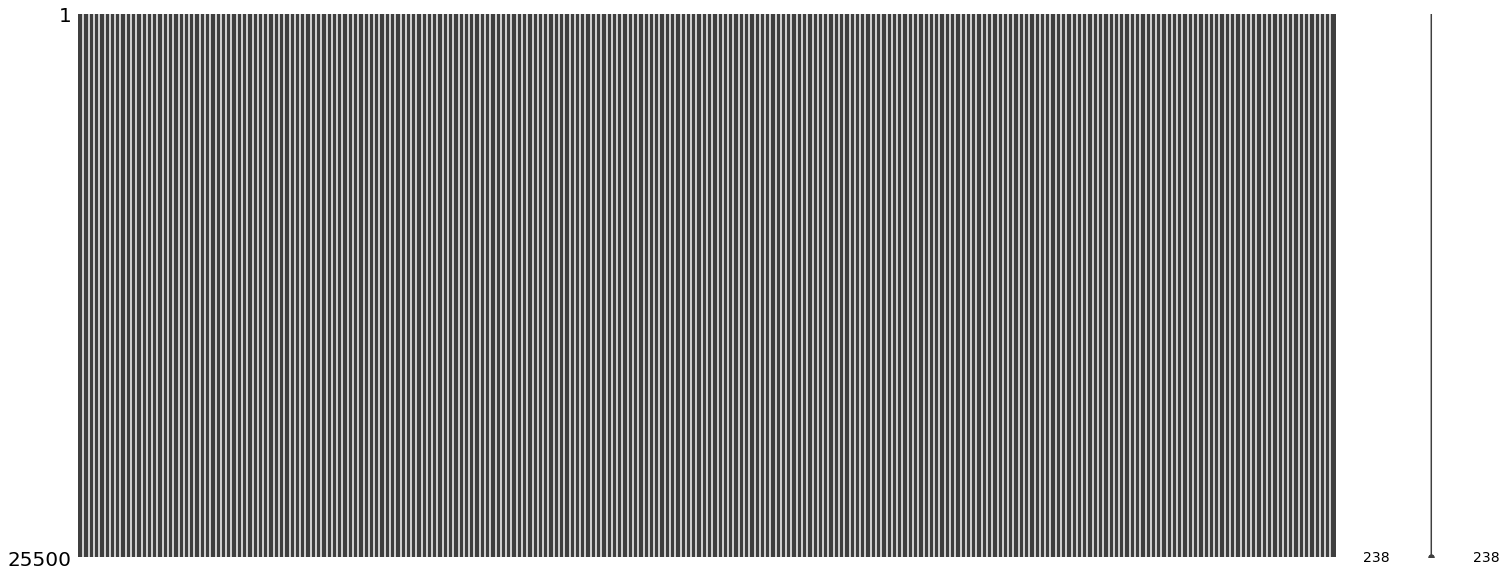

In [18]:
import missingno as msno
msno.matrix(X_train)

### Normalisation du jeu de données <a class="anchor" id="models_prepare_normalize"></a> [⇪](#menu)

> Certains algorithmes de Machine Learning sont sensibles au changement d'échelle des features *(algorithmes basés sur la descente de gradient, algorithmes basés sur la distance)* alors que d'autres *(algorithmes basés sur les arbres...)* y sont pratiquement insensibles.
>
> Comme nous allons essayer plusieurs algorithmes différents, il convient de rendre nos données compatibles avec le plus grand nombre d'algorithmes possibles, donc de toutes les mettre sur une échelle à peu près semblable.
>
> Il existe plusieurs approches pour adapter les données:
> - Le `MinMaxScaler` qui réduit l'intervalle de manière à ce qu'il soit compris entre 0 et 1 *(ou entre -1 et 1 s'il y a des valeurs négatives)*.
> - Le `StandardScaler` qui met à l'échelle les valeurs de sorte que la distribution soit centrée autour de 0, avec un écart-type de 1. *(le `Normalizer` fait la même chose avec les lignes au lieu des colonnes)*.
> - Le `RobustScaler` qui réduit l'intervalle de manière à ce qu'il soit compris entre 0 et 1 *(ou entre -1 et 1 s'il y a des valeurs négatives)* mais en utilisant l'écart interquartile, de sorte qu'il soit plus résistant aux valeurs aberrantes.

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
def fit_normalizer(data):
       
    scaler = MinMaxScaler()
    scaler.fit(data)
    
    return scaler

def normalize(data, robust_scaler):
    
    dt = data.copy()
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

#### On entraine le scaler sur le `train` set

In [21]:
model_scaler = fit_normalizer(X_train)

#### On transforme les données des `training` et `testing` sets

In [22]:
X_train = normalize(X_train, model_scaler)
X_test = normalize(X_test, model_scaler)

### Définissons quelques fonctions pour faciliter la gestion des scores *(rapports, graphiques, enregistrement)* <a class="anchor" id="models_prepare_metrics"></a> [⇪](#menu)

> Nous devons pour cela choisir nos **outils de mesure**.
>
> L'`accuracy` est souvent utilisé pour des modèles de classification, mais c'est en général insuffissant et il faut faire attention à la `precision` et au `recall`. Optimiser des modèles sur la base de plusieurs mesures différentes n'est pas choses aidée, et il est donc habituellement recommandé d'utiliser le `F1-score` qui calcul la moyenne harmonique entre la `precision` et le `recall`.
>
> Cependant, nous sommes ici dans un cas où **le jeu de données est déséquilibré** en faveur des valeurs négatives *(le client ne fait pas défaut)*, et le `F1-score` n'est pas forcement un bon choix avec un tel jeu de données.
>
> Dans un tel cas, il convient d'utiliser des mesures moins sensibles au déséquilibre des classes.
> - Le `Precision-Recall AUC` score est approprié pour les jeux de données très déséquilibré *(ce qui est le cas ici)*, mais il va donner plus de poids à que la classe positive qu'à la classe négative.
> - Le `ROC AUC` score est approprié pour les jeux de données peu ou modérement déséquilibrés, et il va donner autant d'importance à la classe positive qu'à la classe négative.
>
> Les **True Positives** seront des clients que l'on aura considéré comme non solvable avec raison *(donc on **évite une perte**)*.<br>
> Les **True Negatives** seront des clients que l'on aura considéré comme solvable avec raison *(donc on **gagne de l'argent**)*.<br>
> Les **False Positives** seront des clients que l'on aura considéré comme non solvable à tord *(donc on **loupe de l'argent**)*.<br>
> Les **False Negatives** seront des clients que l'on aura considéré comme solvable à tord *(donc on **perd de l'argent**)*.
>
> Dans notre cas, le plus important est de minimiser les pertes d'argent donc les **FN**, mais il semble au moins aussi important de gagner de l'argent et donc de maximiser les **TN**.
>
> On va donc utiliser le `ROC AUC` comme mesure principale, mais enregistrer les autres pour pouvoir tout de même garder un oeil dessus.


In [23]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, average_precision_score

In [24]:
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---".ljust(100,'-'),"\n\n", report)

In [25]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---".ljust(100,'-'),"\n")
    plt.show()

In [26]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- ROC AUC ---".ljust(100,'-'),"\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            roc_score = roc_auc_score(y_true, y_pred)
            sorted_scores[model_name] = roc_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)
    
    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [27]:
from sklearn.metrics import precision_recall_curve

def print_prauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- PRECISION RECALL AUC ---".ljust(100,'-'), "\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            pr_score = average_precision_score(y_true, y_pred)
            sorted_scores[model_name] = pr_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)

    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        pr_score = average_precision_score(y_true, y_pred)
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        
        ax.plot(recall, precision, label=f"{model_name} ({pr_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = pr_score
        
    no_skill = len(y_true[y_true==1]) / len(y_true)            
    ax.plot([0, 1], [no_skill, no_skill], label='No skill', linestyle='--', color='red', alpha=0.3)
    ax.plot([1, 0], [0, 1], label='Balanced', linestyle='--', color='green', alpha=0.5)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [28]:
def save_score(method_name, threshold, param_grid, training_time, inference_time, **scores):
    
    idx = np.where(scores_df.Method == method_name)[0]        
    idx = idx[0] if idx.size > 0 else len(scores_df.index)
    
    rocauc_value = scores.get('roc_auc', None)
    f1_value =  scores.get('f1', None)
    accuracy_value =  scores.get('accuracy', None)
    precision_value =  scores.get('precision', None)
    recall_value = scores.get('recall', None)
    prauc_value = scores.get('average_precision', None)
    TP = scores.get('TP', None)
    FP = scores.get('FP', None)
    TN = scores.get('TN', None)
    FN = scores.get('FN', None)
    
    scores_df.loc[idx] = [method_name, threshold, param_grid, rocauc_value, prauc_value, f1_value, accuracy_value, precision_value, recall_value, TP, TN, FP, FN, training_time, inference_time]    
    scores_df.to_csv(scores_path, index=False)

In [29]:
scores_df = pd.DataFrame(columns=['Method', 'threshold', 'params', 'ROC AUC', 'PR AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'TP', 'TN', 'FP', 'FN', 'Training time', 'Inference time'])
y_preds = {}
scores_path = 'data/scores.csv'
scores_df.to_csv(scores_path, index=False)

def get_scores(method_name, model, X_ref=None, y_ref=None, param_grid=None, threshold=None, training_time=None, inference_time=None, register=False, simple=False, show_classification=True, show_confusion=True, show_roccurves=True, **scores):
    
    if X_ref is None:
        X_ref = X_test
        
    if y_ref is None:
        y_ref = y_test
    
    y_pred, y_pred_proba, inference_time = predict(model, X_ref, threshold)
    cm = confusion_matrix(y_ref, y_pred, labels=[0,1])

    scores = {
        'roc_auc': roc_auc_score(y_ref, y_pred_proba),
        'f1': f1_score(y_ref, y_pred),
        'accuracy': accuracy_score(y_ref, y_pred),
        'precision': precision_score(y_ref, y_pred, zero_division=0),
        'recall': recall_score(y_ref, y_pred),
        'average_precision': average_precision_score(y_ref, y_pred_proba),
        'TN': cm[0][0],
        'FP': cm[0][1],
        'FN': cm[1][0],
        'TP': cm[1][1],
    }
    
    # Register score and replace if it already exists
    if register:
        save_score(method_name, threshold, param_grid, training_time, inference_time, **scores)
    
    # Basic report
    scores_str = ""
    for key in scores.keys():
        if type(scores[key]) == np.float64 and key not in ['TP','TN','FP','FN']:
            scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"
            
    print('-'*100,f'These information are based on the best estimator of the above cross-validation'.center(100,), '-'*100, sep='\n', end='\n\n')
    print(f"--- {method_name} ---".ljust(100,'-'),"\n\n",scores_str, sep="")
          
    if simple:
        return
    
    # Classification report
    if show_classification:
        print_classification_report(y_ref, y_pred)
    
    # Confusion Matrix
    if show_confusion:
        print_confusion_matrix(y_ref, y_pred)
    
    # ROC AUC curves
    if show_roccurves:
        y_preds[method_name] = y_pred_proba
        print_rocauc(y_ref, y_preds)
        print_prauc(y_ref, y_preds)

In [30]:
def predict(model, X_ref, threshold=None):
    t0 = time.perf_counter()
    
    y_pred_proba = model.predict_proba(X_ref)[:,1]
    if threshold:
        y_pred = get_labels_from_threshold(y_pred_proba, threshold)
    else:
        y_pred = model.predict(X_ref)
    
    tt = time.perf_counter() - t0
    return y_pred, y_pred_proba, tt

In [31]:
def get_labels_from_threshold(y_proba, threshold):
    return (y_proba >= threshold).astype('int')

def find_best_threshold(model, X_valid, y_valid, eval_function ):

    best_threshold = 0.0
    best_score = 0.0
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    
    for threshold in np.arange(0, 1, 0.001):
        
        y_pred_threshold = get_labels_from_threshold(y_pred_proba, threshold)
        
        score = eval_function(y_valid, y_pred_threshold)
        if score >= best_threshold:
            best_threshold = threshold
            best_score = score
        
    return best_score, best_threshold

In [32]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV  # --> ne supporte pas le multi-scoring
from sklearn.model_selection import GridSearchCV # --> trop lent


def fit_model(model_name, model, X_ref=None, y_ref=None, param_grid = {}, scoring='roc_auc', cv=5, verbose=2, register=True):
    
    if X_ref is None:
        X_ref = X_train
        
    if y_ref is None:
        y_ref = y_train
        
    fit_time = time.perf_counter()
    grid_model = HalvingGridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, min_resources=500)
    #grid_model = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, refit="roc_auc", return_train_score=True)
    grid_model.fit(X_ref, y_ref)
    fit_time = time.perf_counter() - fit_time

    results = grid_model.cv_results_
    n_splits = cv.n_splits if hasattr(cv, 'n_splits') else cv
    sets_list = ["test"] if verbose < 3 else ["train", "test"]
    
    # Print K-fold scores
    if verbose > 1:
        for i in range(n_splits):
            print(f"".center(100,'-'))
        
            for sample in sets_list:
                scores_str = f"{scoring.upper()}: {results[f'split{i}_{sample}_score'].mean():.4f}"
                print(f"FOLD-{i+1} {sample.upper().rjust(6)} scores | {scores_str}")
                
    # Print overall scores
    if verbose > 0:
   
        for sample in sets_list:
            print('\n', f" {sample.upper()}-CV-SPLIT MEAN SCORES ".center(100,'-'), sep='')
            mean_str = f"{scoring.upper()}: {results[f'mean_{sample}_score'].mean():.4f} (std:{results[f'std_{sample}_score'].mean():.4f})"
            print(f"\n- {mean_str}")
            
        print("\n", f"".center(100,'-'), sep='')
    
    inf_time = pd.Series(grid_model.cv_results_['mean_score_time']).mean()
    
    return {'grid':grid_model, 'model':grid_model.best_estimator_, 'training_time':fit_time, 'inference_time':inf_time, 'param_grid':param_grid} #, **scores_args}

In [33]:
def get_model_name(model):
    index = str(model).index('(')
    return str(model)[:index]

#### Let's define the cross-validation method

In [34]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [35]:
import FreeMobileSMS as sms
sms.send("Data preparation done", stop=False)

# Essayons quelques algorithmes sans optimisation <a class="anchor" id="models"></a> [⇪](#menu)

## 1. Établissons une base-line avec un algorithm naïf *(Dummy Classifier)* <a class="anchor" id="models_dummy"></a> [⇪](#menu)

In [36]:
from sklearn.dummy import DummyClassifier

In [37]:
model_name = "DummyClassifier"

In [38]:
grd_dummy = fit_model( 
    model_name,
    DummyClassifier(),
    param_grid={ 'random_state':[0], 'strategy':['stratified'] }, 
    cv = skfold,
    verbose=2,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.4521
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.4516
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.4962
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.4489
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.4536

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.4605 (std:0.0179)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- DummyClassifier --------------------------------------------------------------------------------

             ROC_AUC : 0.4905
                  F1 : 0.0666
            ACCURACY : 0.8442
           PRECISION : 0.0639
              RECALL : 0.0694
   AVERAGE_PRECISION : 0.0789

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.91      0.92      4140
Prediction = 1       0.06      0.07      0.07       360

      accuracy                           0.84      4500
     macro avg       0.49      0.49      0.49      4500
  weighted avg       0.85  

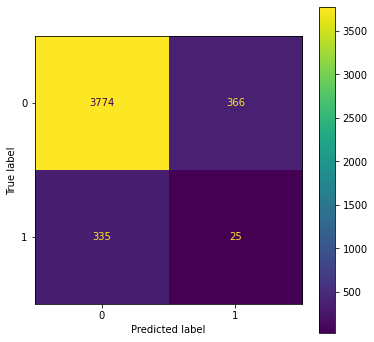

--- ROC AUC ---------------------------------------------------------------------------------------- 



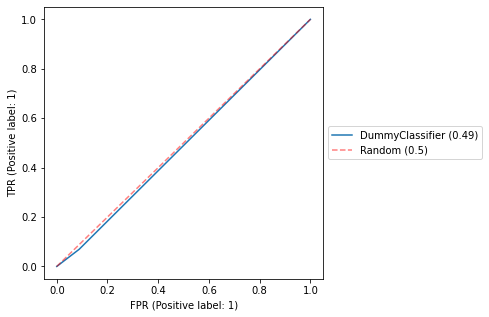

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



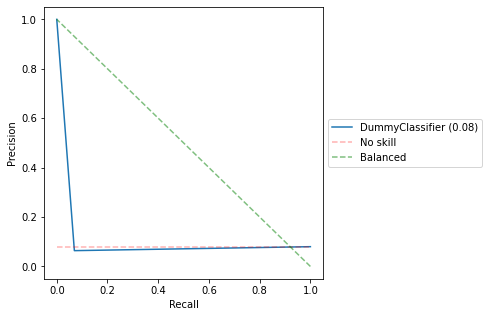

In [39]:
get_scores(model_name, **grd_dummy, register=True)

## 2. Essayons un algorithme linéaire - Logistic Regression <a class="anchor" id="models_linear"></a> [⇪](#menu)

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
model_name = "Basic LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid={ 'random_state':[0], 'max_iter':[3000] },  
    cv = skfold,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7242
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7009
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5924
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.9255
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5469

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6980 (std:0.1315)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic LogisticRegression -----------------------------------------------------------------------

             ROC_AUC : 0.7330
                  F1 : 0.0055
            ACCURACY : 0.9191
           PRECISION : 0.1667
              RECALL : 0.0028
   AVERAGE_PRECISION : 0.1999

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.17      0.00      0.01       360

      accuracy                           0.92      4500
     macro avg       0.54      0.50      0.48      4500
  weighted avg       0.86  

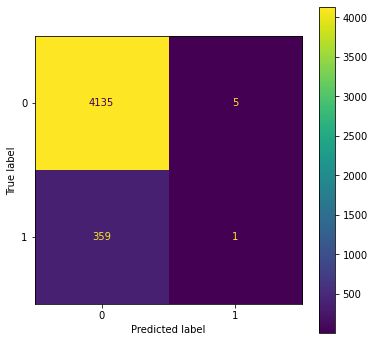

--- ROC AUC ---------------------------------------------------------------------------------------- 



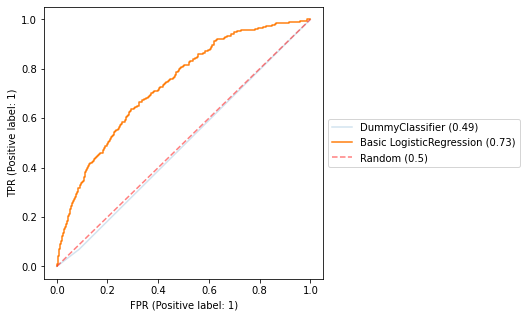

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



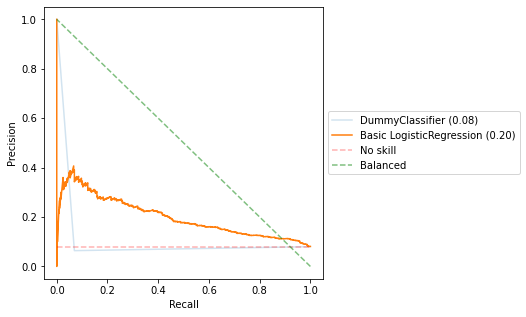

In [42]:
get_scores(model_name, **grd_log, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [43]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.24287028518859247) for this model is reached with a threshold of 0.241


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic LogisticRegression [w/thresholding] ------------------------------------------------------

             ROC_AUC : 0.7330
                  F1 : 0.2039
            ACCURACY : 0.8993
           PRECISION : 0.2775
              RECALL : 0.1611
   AVERAGE_PRECISION : 0.1999

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.96      0.95      4140
Prediction = 1       0.28      0.16      0.20       360

      accuracy                           0.90      4500
     macro avg       0.60      0.56      0.58      4500
  weighted avg       0.88  

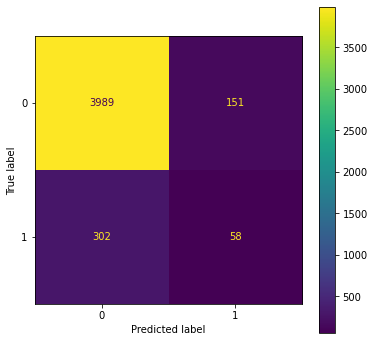

In [44]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Essayons un algorithme non-linéaire - Decision Tree <a class="anchor" id="models_decision_tree"></a> [⇪](#menu)

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
model_name = "Basic DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid={ 'random_state':[0] }, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.4574
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6549
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5474
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5833
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.4526

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5391 (std:0.0769)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic DecisionTreeClassifier -------------------------------------------------------------------

             ROC_AUC : 0.5213
                  F1 : 0.1224
            ACCURACY : 0.8471
           PRECISION : 0.1132
              RECALL : 0.1333
   AVERAGE_PRECISION : 0.0844

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.91      0.92      4140
Prediction = 1       0.11      0.13      0.12       360

      accuracy                           0.85      4500
     macro avg       0.52      0.52      0.52      4500
  weighted avg       0.86  

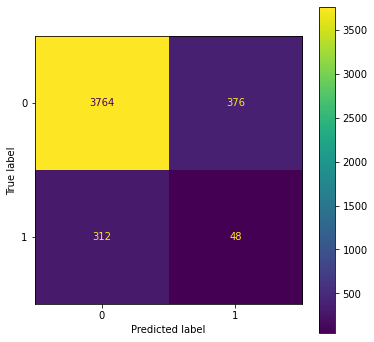

--- ROC AUC ---------------------------------------------------------------------------------------- 



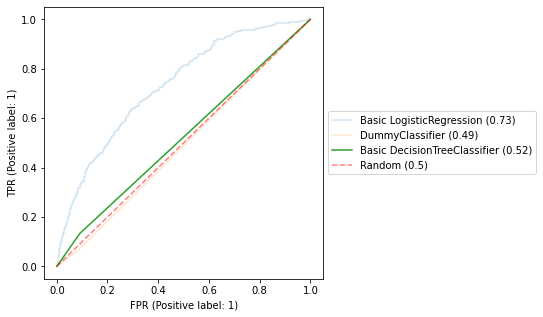

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



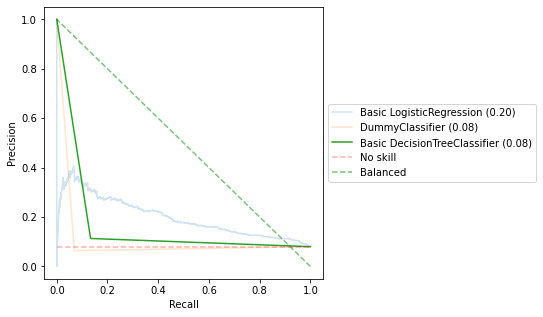

In [47]:
get_scores(model_name, **grd_dt, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [48]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (1.0) for this model is reached with a threshold of 0.999


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic DecisionTreeClassifier [w/thresholding] --------------------------------------------------

             ROC_AUC : 0.5213
                  F1 : 0.1224
            ACCURACY : 0.8471
           PRECISION : 0.1132
              RECALL : 0.1333
   AVERAGE_PRECISION : 0.0844

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.91      0.92      4140
Prediction = 1       0.11      0.13      0.12       360

      accuracy                           0.85      4500
     macro avg       0.52      0.52      0.52      4500
  weighted avg       0.86  

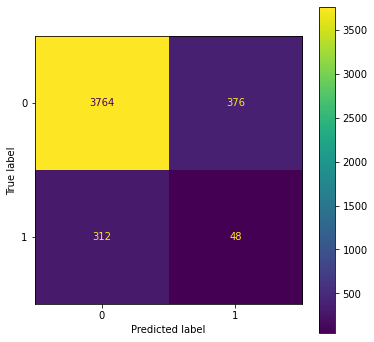

In [49]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 4. Essayons un autre algorithme non-linéaire - KNN *(k-nearest neighbors)* <a class="anchor" id="models_knn"></a> [⇪](#menu)

In [50]:
from sklearn.neighbors import KNeighborsClassifier

In [51]:
model_name = "Basic KNeighborsClassifier"

grd_knn = fit_model(
    model_name,
    KNeighborsClassifier(n_jobs=-1), 
    param_grid={},  
    cv = skfold,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5589
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.4484
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6897
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5853
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5867

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5738 (std:0.0770)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic KNeighborsClassifier ---------------------------------------------------------------------

             ROC_AUC : 0.5411
                  F1 : 0.0103
            ACCURACY : 0.9147
           PRECISION : 0.0714
              RECALL : 0.0056
   AVERAGE_PRECISION : 0.0890

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      4140
Prediction = 1       0.07      0.01      0.01       360

      accuracy                           0.91      4500
     macro avg       0.50      0.50      0.48      4500
  weighted avg       0.85  

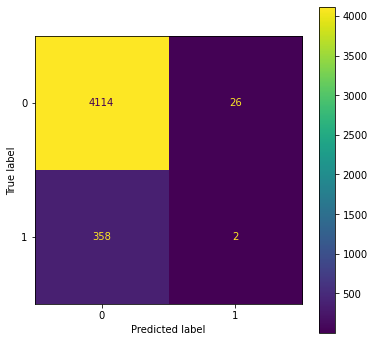

--- ROC AUC ---------------------------------------------------------------------------------------- 



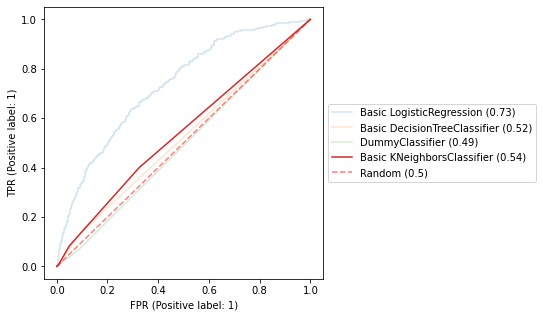

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



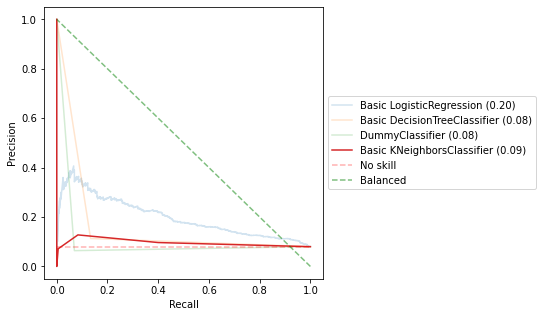

In [52]:
get_scores(model_name, **grd_knn, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [53]:
f1_value, best_threshold = find_best_threshold(grd_knn['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.38864755285259195) for this model is reached with a threshold of 0.389


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic KNeighborsClassifier [w/thresholding] ----------------------------------------------------

             ROC_AUC : 0.5411
                  F1 : 0.1008
            ACCURACY : 0.8811
           PRECISION : 0.1277
              RECALL : 0.0833
   AVERAGE_PRECISION : 0.0890

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.95      0.94      4140
Prediction = 1       0.13      0.08      0.10       360

      accuracy                           0.88      4500
     macro avg       0.53      0.52      0.52      4500
  weighted avg       0.86  

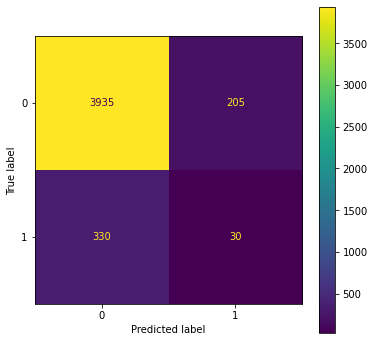

In [54]:
get_scores(f"{model_name} [w/thresholding]", **grd_knn, threshold=best_threshold, register=True, show_roccurves=False)

## 5. Essayons un algorithme d'ensemble - Random Forest <a class="anchor" id="models_random_forest"></a> [⇪](#menu)

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
model_name = "Basic RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid={ 'random_state':[0] }, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.4459
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6032
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5685
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7018
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.3024

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5243 (std:0.1379)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic RandomForestClassifier -------------------------------------------------------------------

             ROC_AUC : 0.6861
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1708

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

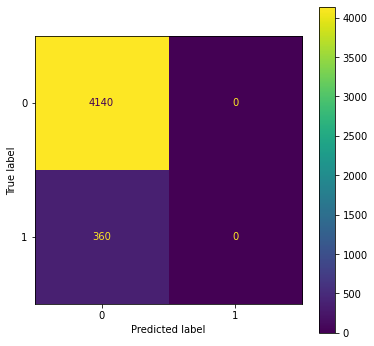

--- ROC AUC ---------------------------------------------------------------------------------------- 



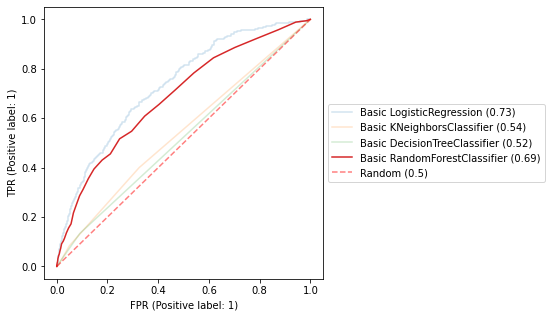

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



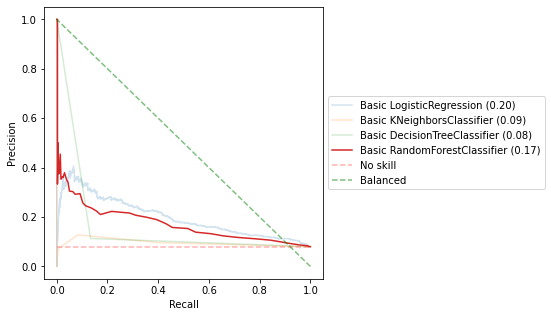

In [57]:
get_scores(model_name, **grd_rf, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [58]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.7118537200504413) for this model is reached with a threshold of 0.68


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic RandomForestClassifier [w/thresholding] --------------------------------------------------

             ROC_AUC : 0.6861
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1708

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

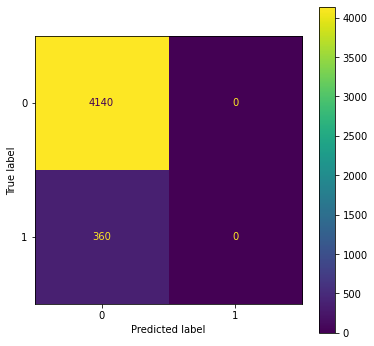

In [59]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 6. Essayons un autre algorithme d'ensemble - XGBoost Classifier <a class="anchor" id="models_xgboost"></a> [⇪](#menu)

In [60]:
from xgboost import XGBClassifier

In [61]:
model_name = "Basic XGBClassifier"

param_grid = {
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
}

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5747
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5444
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7404
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.8479
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5869

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6589 (std:0.1164)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic XGBClassifier ----------------------------------------------------------------------------

             ROC_AUC : 0.7137
                  F1 : 0.1117
            ACCURACY : 0.9187
           PRECISION : 0.4423
              RECALL : 0.0639
   AVERAGE_PRECISION : 0.2145

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      4140
Prediction = 1       0.44      0.06      0.11       360

      accuracy                           0.92      4500
     macro avg       0.68      0.53      0.53      4500
  weighted avg       0.89  

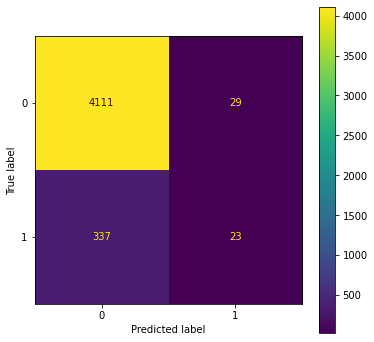

--- ROC AUC ---------------------------------------------------------------------------------------- 



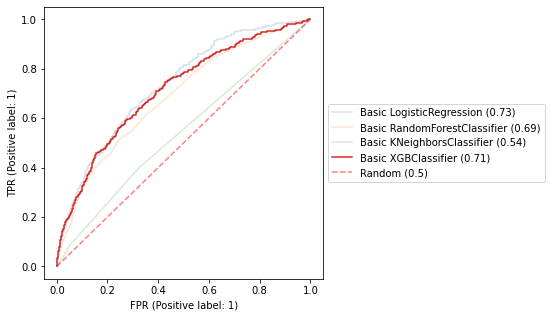

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



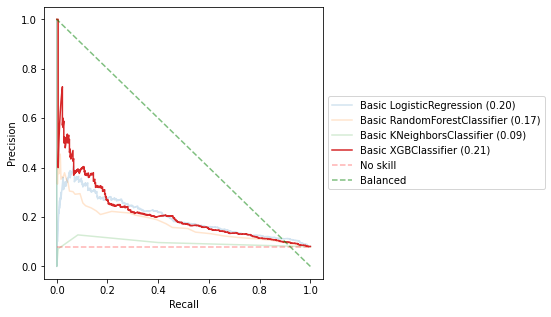

In [62]:
get_scores(model_name, **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [63]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.5625879043600562) for this model is reached with a threshold of 0.561


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic XGBClassifier [w/thresholding] -----------------------------------------------------------

             ROC_AUC : 0.7137
                  F1 : 0.0724
            ACCURACY : 0.9202
           PRECISION : 0.5185
              RECALL : 0.0389
   AVERAGE_PRECISION : 0.2145

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.52      0.04      0.07       360

      accuracy                           0.92      4500
     macro avg       0.72      0.52      0.52      4500
  weighted avg       0.89  

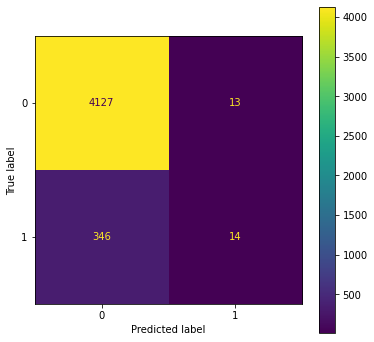

In [64]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 7. Revue des scores <a class="anchor" id="models_scores"></a> [⇪](#menu)

In [65]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Basic')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
1,Basic LogisticRegression,0.732972,0.005464,0.002778
3,Basic DecisionTreeClassifier,0.521256,0.122449,0.133333
5,Basic KNeighborsClassifier,0.541067,0.010309,0.005556
7,Basic RandomForestClassifier,0.686125,0.000000,0.000000
9,Basic XGBClassifier,0.713682,0.111650,0.063889


In [66]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Basic')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
2,Basic LogisticRegression [w/thresholding],0.732972,0.203866,0.161111
4,Basic DecisionTreeClassifier [w/thresholding],0.521256,0.122449,0.133333
6,Basic KNeighborsClassifier [w/thresholding],0.541067,0.100840,0.083333
8,Basic RandomForestClassifier [w/thresholding],0.686125,0.000000,0.000000
10,Basic XGBClassifier [w/thresholding],0.713682,0.072351,0.038889


In [67]:
sms.send("Basic done", stop=False)

# Recherche des meilleurs paramètres avec GreadSearchCV <a class="anchor" id="models_grid"></a> [⇪](#menu)

## 1. Logistic Regression Grid<a class="anchor" id="models_linear_grid"></a> [⇪](#menu)

In [68]:
param_grid = [
    {
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [69]:
model_name = "Grid LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6218
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6494
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6218
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6241
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5437

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6121 (std:0.0703)

----------------------------------------------------------------------------------------------------


In [70]:
grd_log['grid'].best_params_

{'C': 0.1,
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid LogisticRegression ------------------------------------------------------------------------

             ROC_AUC : 0.7338
                  F1 : 0.0000
            ACCURACY : 0.9193
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.2046

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

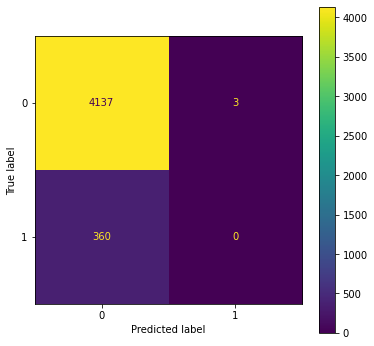

--- ROC AUC ---------------------------------------------------------------------------------------- 



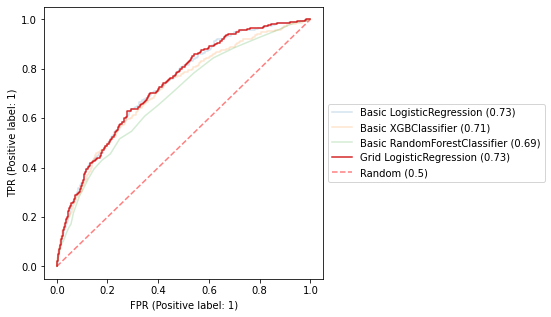

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



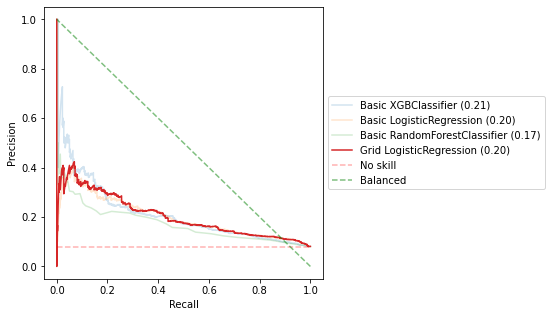

In [71]:
get_scores(model_name, **grd_log, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [72]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.23127962085308057) for this model is reached with a threshold of 0.232


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid LogisticRegression [w/thresholding] -------------------------------------------------------

             ROC_AUC : 0.7338
                  F1 : 0.2230
            ACCURACY : 0.9040
           PRECISION : 0.3163
              RECALL : 0.1722
   AVERAGE_PRECISION : 0.2046

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.97      0.95      4140
Prediction = 1       0.32      0.17      0.22       360

      accuracy                           0.90      4500
     macro avg       0.62      0.57      0.59      4500
  weighted avg       0.88  

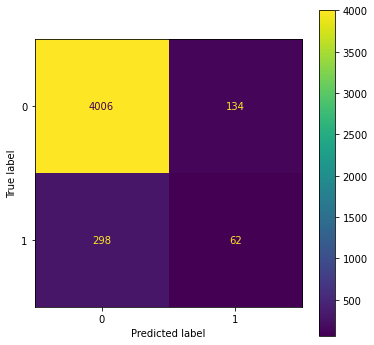

In [73]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 2. Decision Tree Grid <a class="anchor" id="models_decision_tree_grid"></a> [⇪](#menu)

In [74]:
param_grid = {
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [75]:
model_name = "Grid DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5767
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5319
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5260
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5396
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5372

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5423 (std:0.0494)

----------------------------------------------------------------------------------------------------


In [76]:
grd_dt['grid'].best_params_

{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': None,
 'random_state': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid DecisionTreeClassifier --------------------------------------------------------------------

             ROC_AUC : 0.6833
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1455

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

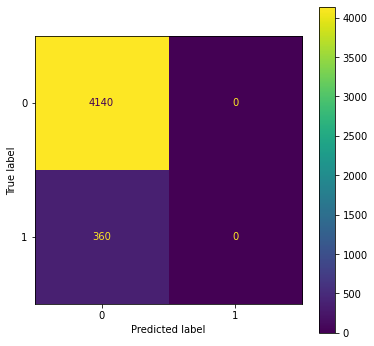

--- ROC AUC ---------------------------------------------------------------------------------------- 



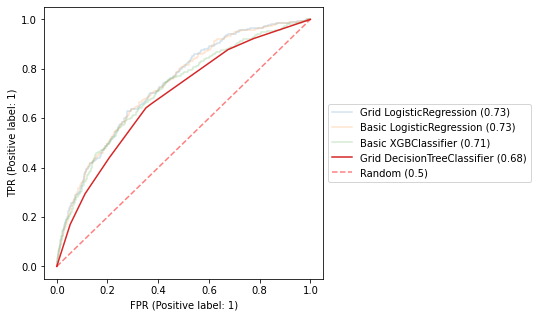

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



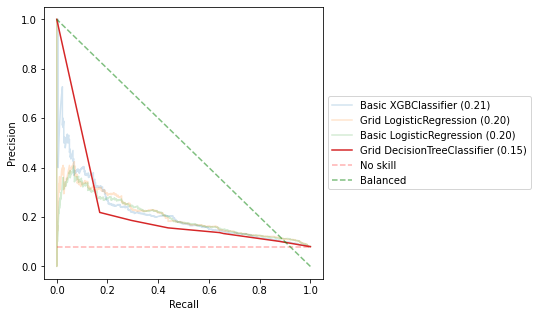

In [77]:
get_scores(model_name, **grd_dt, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [78]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.20944444444444446) for this model is reached with a threshold of 0.21


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid DecisionTreeClassifier [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.6833
                  F1 : 0.1909
            ACCURACY : 0.8851
           PRECISION : 0.2186
              RECALL : 0.1694
   AVERAGE_PRECISION : 0.1455

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.95      0.94      4140
Prediction = 1       0.22      0.17      0.19       360

      accuracy                           0.89      4500
     macro avg       0.57      0.56      0.56      4500
  weighted avg       0.87  

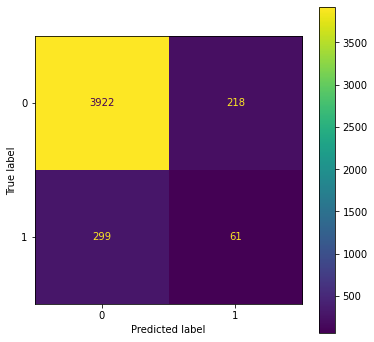

In [79]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Random Forest Grid <a class="anchor" id="models_random_forest_grid"></a> [⇪](#menu)

In [80]:
param_grid = {
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 512]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [81]:
model_name = "Grid RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5857
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5458
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6065
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.8450
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5804

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6327 (std:0.1165)

----------------------------------------------------------------------------------------------------


In [82]:
grd_rf['grid'].best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': None,
 'n_estimators': 500,
 'random_state': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid RandomForestClassifier --------------------------------------------------------------------

             ROC_AUC : 0.7180
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1974

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

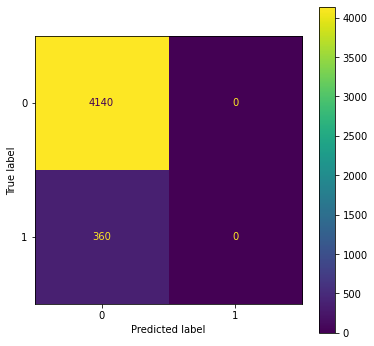

--- ROC AUC ---------------------------------------------------------------------------------------- 



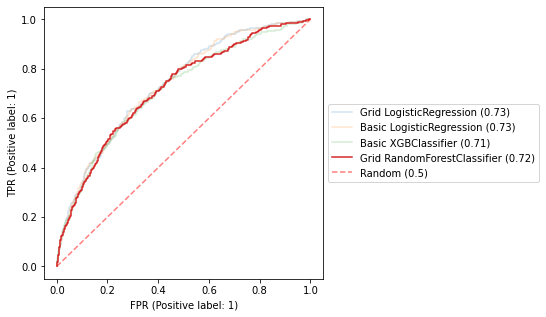

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



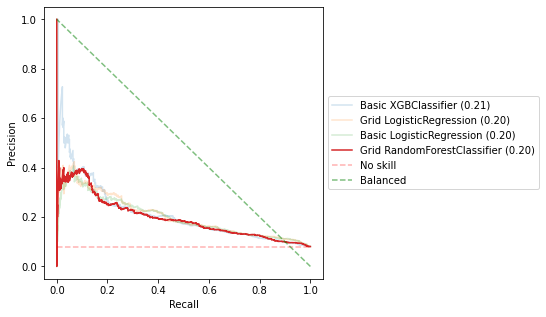

In [83]:
get_scores(model_name, **grd_rf, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédictions *(sur la base du F1 score)*

In [84]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2866191607284244) for this model is reached with a threshold of 0.28400000000000003


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid RandomForestClassifier [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.7180
                  F1 : 0.1132
            ACCURACY : 0.9164
           PRECISION : 0.3750
              RECALL : 0.0667
   AVERAGE_PRECISION : 0.1974

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      4140
Prediction = 1       0.38      0.07      0.11       360

      accuracy                           0.92      4500
     macro avg       0.65      0.53      0.53      4500
  weighted avg       0.88  

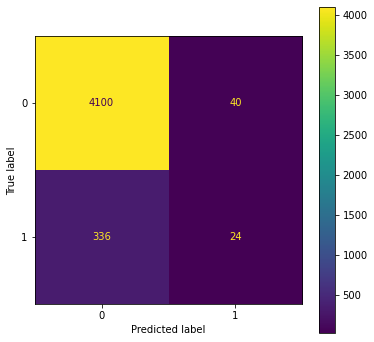

In [85]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 4. XGBoost Classifier Grid<a class="anchor" id="models_xgboost_grid"></a> [⇪](#menu)

In [86]:
from xgboost import XGBClassifier

In [87]:
param_grid = {
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [88]:
model_name = "Grid XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6635
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5879
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6655
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6488
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6503

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6432 (std:0.0543)

----------------------------------------------------------------------------------------------------


In [89]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 180,
 'nthread': -1,
 'objective': 'binary:logistic',
 'seed': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid XGBClassifier -----------------------------------------------------------------------------

             ROC_AUC : 0.7270
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.2076

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

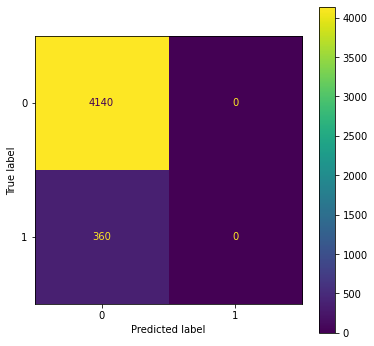

--- ROC AUC ---------------------------------------------------------------------------------------- 



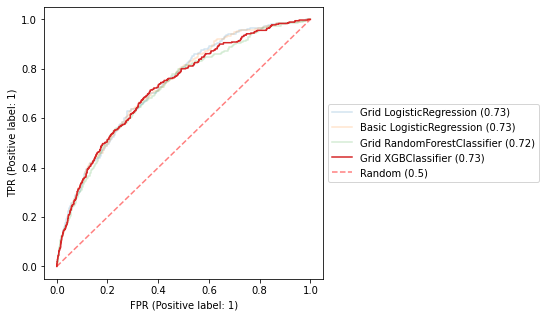

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



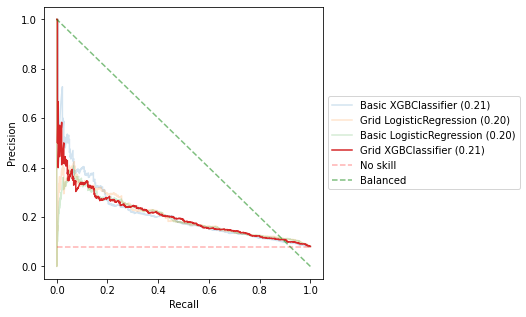

In [90]:
get_scores(model_name, **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [91]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.22672064777327935) for this model is reached with a threshold of 0.227


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid XGBClassifier [w/thresholding] ------------------------------------------------------------

             ROC_AUC : 0.7270
                  F1 : 0.1907
            ACCURACY : 0.9076
           PRECISION : 0.3182
              RECALL : 0.1361
   AVERAGE_PRECISION : 0.2076

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.97      0.95      4140
Prediction = 1       0.32      0.14      0.19       360

      accuracy                           0.91      4500
     macro avg       0.62      0.56      0.57      4500
  weighted avg       0.88  

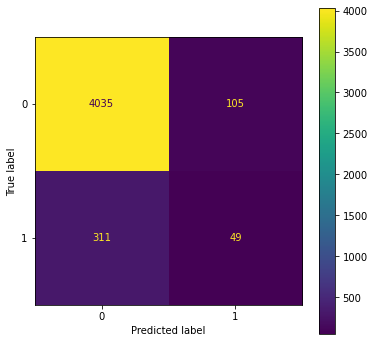

In [92]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 5. KNN *(k-nearest neighbors)* Grid <a class="anchor" id="models_knn_grid"></a> [⇪](#menu)

In [93]:
param_grid = {
    'n_neighbors': list(range(1,35,2)), # tous les chiffres impairs de 1 à 33 inclus
    #'weight_options': ['uniform', 'distance']
}

In [94]:
model_name = "Grid KNeighborsClassifier"

grd_knn = fit_model(
    model_name,
    KNeighborsClassifier(n_jobs=-1), 
    param_grid=param_grid,  
    cv = skfold,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5580
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.4285
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5504
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.4980
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.4469

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.4963 (std:0.0892)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid KNeighborsClassifier ----------------------------------------------------------------------

             ROC_AUC : 0.6058
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1105

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

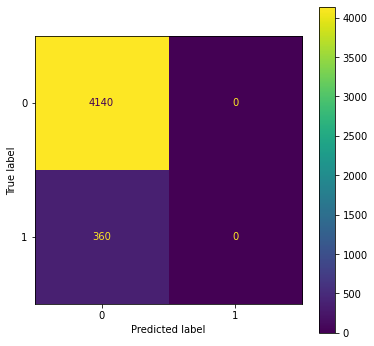

--- ROC AUC ---------------------------------------------------------------------------------------- 



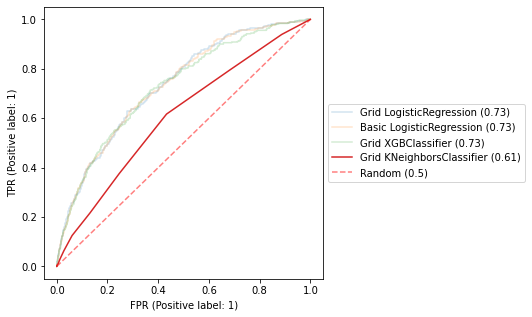

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



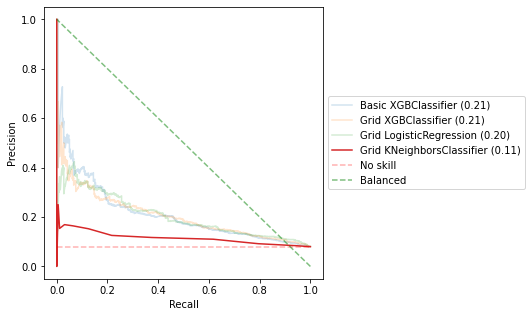

In [95]:
get_scores(model_name, **grd_knn, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [96]:
f1_value, best_threshold = find_best_threshold(grd_knn['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.24134256792754397) for this model is reached with a threshold of 0.181


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid KNeighborsClassifier [w/thresholding] -----------------------------------------------------

             ROC_AUC : 0.6058
                  F1 : 0.1374
            ACCURACY : 0.8744
           PRECISION : 0.1525
              RECALL : 0.1250
   AVERAGE_PRECISION : 0.1105

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.94      0.93      4140
Prediction = 1       0.15      0.12      0.14       360

      accuracy                           0.87      4500
     macro avg       0.54      0.53      0.53      4500
  weighted avg       0.86  

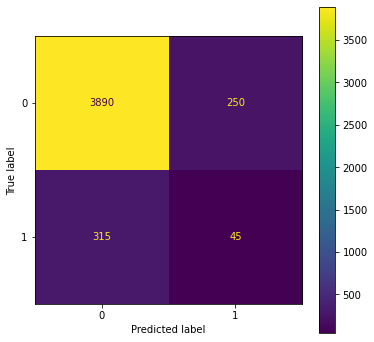

In [97]:
get_scores(f"{model_name} [w/thresholding]", **grd_knn, threshold=best_threshold, register=True, show_roccurves=False)

## 6. Revue des scores <a class="anchor" id="models_grid_scores"></a> [⇪](#menu)

In [98]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier,None,"{'random_state': [0], 'strategy': ['stratified']}",0.490519,0.078885,0.066578,0.844222,0.063939,0.069444,25,3774,366,335,1.199276,0.002503
1,Basic LogisticRegression,None,"{'random_state': [0], 'max_iter': [3000]}",0.732972,0.199926,0.005464,0.919111,0.166667,0.002778,1,4135,5,359,5.815437,0.040237
2,Basic LogisticRegression [w/thresholding],0.241,"{'random_state': [0], 'max_iter': [3000]}",0.732972,0.199926,0.203866,0.899333,0.277512,0.161111,58,3989,151,302,5.815437,0.003992
3,Basic DecisionTreeClassifier,None,{'random_state': [0]},0.521256,0.084428,0.122449,0.847111,0.113208,0.133333,48,3764,376,312,2.256247,0.013005
4,Basic DecisionTreeClassifier [w/thresholding],0.999,{'random_state': [0]},0.521256,0.084428,0.122449,0.847111,0.113208,0.133333,48,3764,376,312,2.256247,0.009362
5,Basic KNeighborsClassifier,None,{},0.541067,0.088950,0.010309,0.914667,0.071429,0.005556,2,4114,26,358,0.238977,7.527614
6,Basic KNeighborsClassifier [w/thresholding],0.389,{},0.541067,0.088950,0.100840,0.881111,0.127660,0.083333,30,3935,205,330,0.238977,3.542919
7,Basic RandomForestClassifier,None,{'random_state': [0]},0.686125,0.170760,0.000000,0.920000,0.000000,0.000000,0,4140,0,360,2.892661,0.134649
8,Basic RandomForestClassifier [w/thresholding],0.68,{'random_state': [0]},0.686125,0.170760,0.000000,0.920000,0.000000,0.000000,0,4140,0,360,2.892661,0.078468
9,Basic XGBClassifier,None,"{'seed': [0], 'objective': ['binary:logistic']...",0.713682,0.214494,0.111650,0.918667,0.442308,0.063889,23,4111,29,337,8.853084,0.041406


In [99]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Grid')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
11,Grid LogisticRegression,0.733814,0.0,0.0
13,Grid DecisionTreeClassifier,0.683334,0.0,0.0
15,Grid RandomForestClassifier,0.718028,0.0,0.0
17,Grid XGBClassifier,0.726969,0.0,0.0
19,Grid KNeighborsClassifier,0.605833,0.0,0.0


In [100]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Grid')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
12,Grid LogisticRegression [w/thresholding],0.733814,0.223022,0.172222
14,Grid DecisionTreeClassifier [w/thresholding],0.683334,0.190923,0.169444
16,Grid RandomForestClassifier [w/thresholding],0.718028,0.113208,0.066667
18,Grid XGBClassifier [w/thresholding],0.726969,0.190661,0.136111
20,Grid KNeighborsClassifier [w/thresholding],0.605833,0.137405,0.125000


In [101]:
sms.send("Gridsearch done", stop=False)

# Amélioration des modèles avec `class_weight` pour contre balancer le déséquilibrage des classes <a class="anchor" id="models_balanced"></a> [⇪](#menu)

## 1. Logistic Regression balanced with `class_weight` + Grid search<a class="anchor" id="models_linear_balanced"></a> [⇪](#menu)

In [102]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [103]:
model_name = "Balanced LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5683
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6803
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5960
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6238
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5358

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6008 (std:0.0674)

----------------------------------------------------------------------------------------------------


In [104]:
grd_log['grid'].best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'liblinear'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced LogisticRegression --------------------------------------------------------------------

             ROC_AUC : 0.7331
                  F1 : 0.2447
            ACCURACY : 0.6762
           PRECISION : 0.1504
              RECALL : 0.6556
   AVERAGE_PRECISION : 0.2029

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.66      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.67      0.52      4500
  weighted avg       0.89  

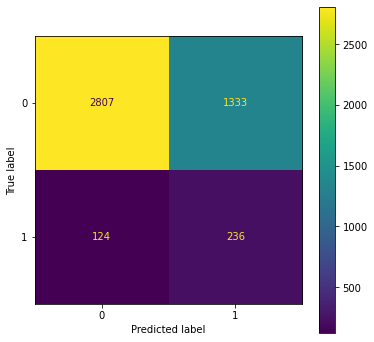

--- ROC AUC ---------------------------------------------------------------------------------------- 



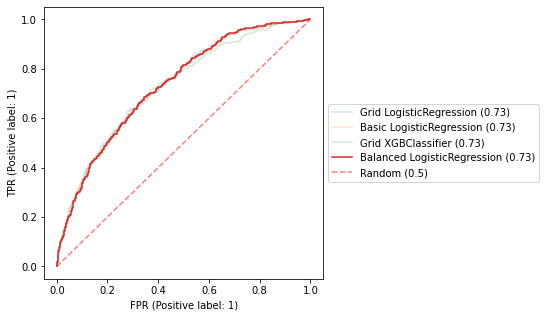

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



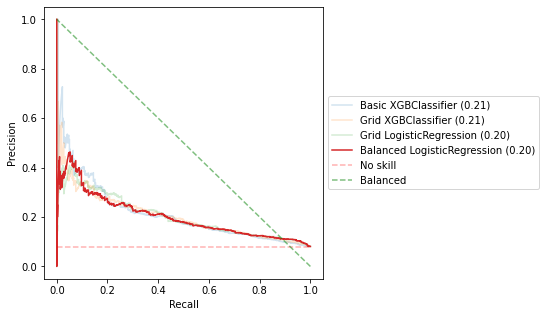

In [105]:
get_scores(model_name, **grd_log, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [106]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.23826550019018636) for this model is reached with a threshold of 0.436


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced LogisticRegression [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.7331
                  F1 : 0.2241
            ACCURACY : 0.5891
           PRECISION : 0.1320
              RECALL : 0.7417
   AVERAGE_PRECISION : 0.2029

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.58      0.72      4140
Prediction = 1       0.13      0.74      0.22       360

      accuracy                           0.59      4500
     macro avg       0.55      0.66      0.47      4500
  weighted avg       0.90  

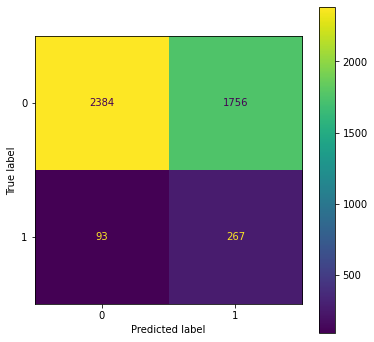

In [107]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 2. Decision Tree balanced with `class_weight` + Grid search <a class="anchor" id="models_decision_tree_balanced"></a> [⇪](#menu)

In [108]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [109]:
model_name = "Balanced DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5300
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5306
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5845
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6467
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5671

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5718 (std:0.0736)

----------------------------------------------------------------------------------------------------


In [110]:
grd_dt['grid'].best_params_

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None,
 'random_state': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced DecisionTreeClassifier ----------------------------------------------------------------

             ROC_AUC : 0.6797
                  F1 : 0.2322
            ACCURACY : 0.6958
           PRECISION : 0.1455
              RECALL : 0.5750
   AVERAGE_PRECISION : 0.1417

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.71      0.81      4140
Prediction = 1       0.15      0.57      0.23       360

      accuracy                           0.70      4500
     macro avg       0.55      0.64      0.52      4500
  weighted avg       0.89  

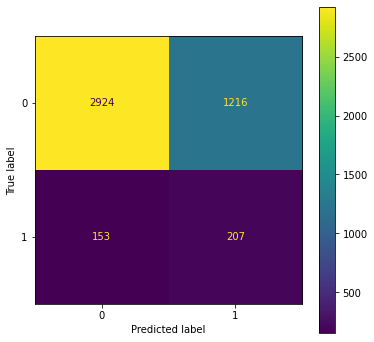

--- ROC AUC ---------------------------------------------------------------------------------------- 



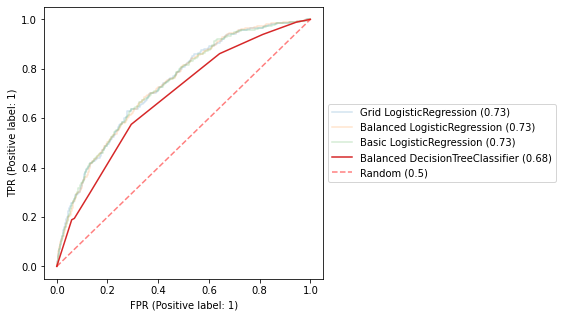

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



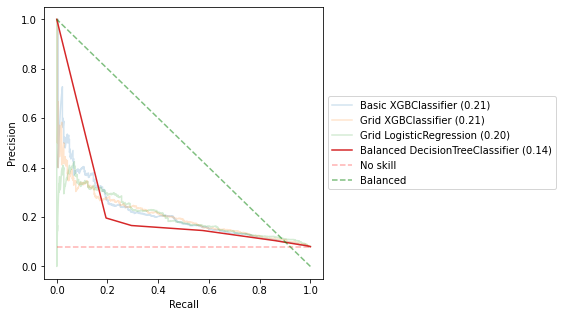

In [111]:
get_scores(model_name, **grd_dt, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [112]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.24657816198415147) for this model is reached with a threshold of 0.424


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced DecisionTreeClassifier [w/thresholding] -----------------------------------------------

             ROC_AUC : 0.6797
                  F1 : 0.2322
            ACCURACY : 0.6958
           PRECISION : 0.1455
              RECALL : 0.5750
   AVERAGE_PRECISION : 0.1417

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.71      0.81      4140
Prediction = 1       0.15      0.57      0.23       360

      accuracy                           0.70      4500
     macro avg       0.55      0.64      0.52      4500
  weighted avg       0.89  

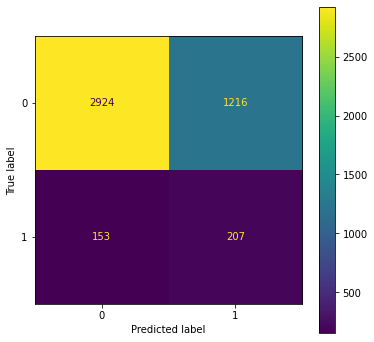

In [113]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Random Forest balanced with `class_weight` + Grid search<a class="anchor" id="models_random_forest_balanced"></a> [⇪](#menu)

In [114]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 528]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [115]:
model_name = "Balanced RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6577
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5784
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6803
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7265
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7180

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6722 (std:0.0739)

----------------------------------------------------------------------------------------------------


In [116]:
grd_rf['grid'].best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'n_estimators': 100,
 'random_state': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced RandomForestClassifier ----------------------------------------------------------------

             ROC_AUC : 0.7077
                  F1 : 0.2396
            ACCURACY : 0.6982
           PRECISION : 0.1501
              RECALL : 0.5944
   AVERAGE_PRECISION : 0.1996

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.71      0.81      4140
Prediction = 1       0.15      0.59      0.24       360

      accuracy                           0.70      4500
     macro avg       0.55      0.65      0.53      4500
  weighted avg       0.89  

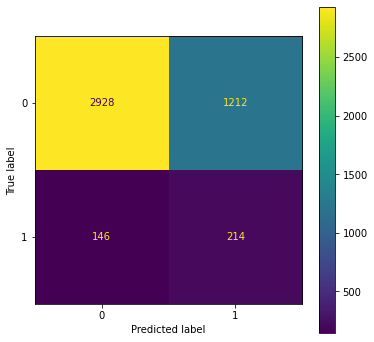

--- ROC AUC ---------------------------------------------------------------------------------------- 



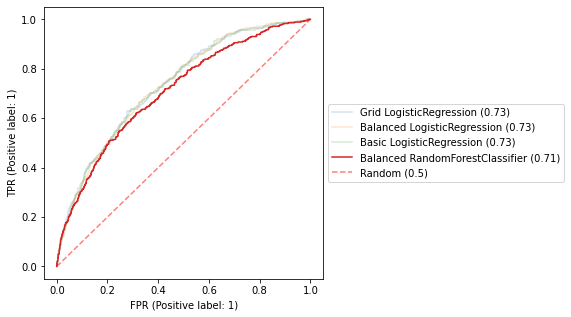

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



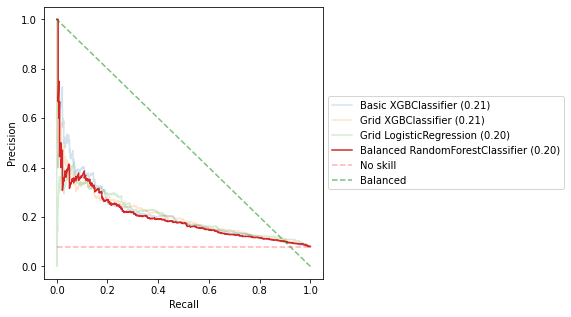

In [117]:
get_scores(model_name, **grd_rf, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [118]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.21451293439769523) for this model is reached with a threshold of 0.39


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced RandomForestClassifier [w/thresholding] -----------------------------------------------

             ROC_AUC : 0.7077
                  F1 : 0.1971
            ACCURACY : 0.4640
           PRECISION : 0.1120
              RECALL : 0.8222
   AVERAGE_PRECISION : 0.1996

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.43      0.60      4140
Prediction = 1       0.11      0.82      0.20       360

      accuracy                           0.46      4500
     macro avg       0.54      0.63      0.40      4500
  weighted avg       0.90  

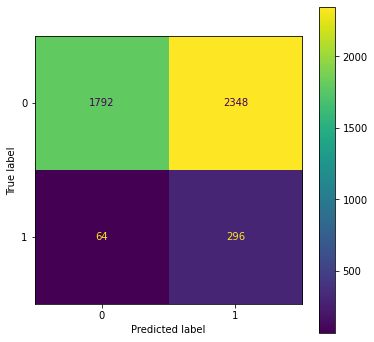

In [119]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 4. XGBoost Classifier balanced with `class_weight` + Grid search<a class="anchor" id="models_xgboost_balanced"></a> [⇪](#menu)

In [120]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [121]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [122]:
model_name = "Balanced XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6501
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5788
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6906
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6786
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6420

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6480 (std:0.0768)

----------------------------------------------------------------------------------------------------


In [123]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 140,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.481644640234949,
 'seed': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced XGBClassifier -------------------------------------------------------------------------

             ROC_AUC : 0.7240
                  F1 : 0.2396
            ACCURACY : 0.6784
           PRECISION : 0.1478
              RECALL : 0.6333
   AVERAGE_PRECISION : 0.2060

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.80      4140
Prediction = 1       0.15      0.63      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      4500
  weighted avg       0.89  

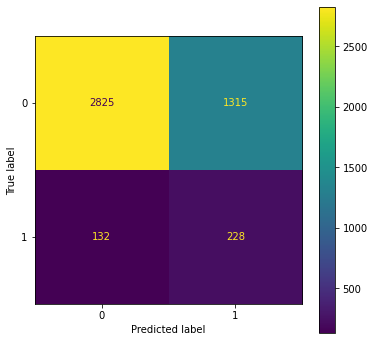

--- ROC AUC ---------------------------------------------------------------------------------------- 



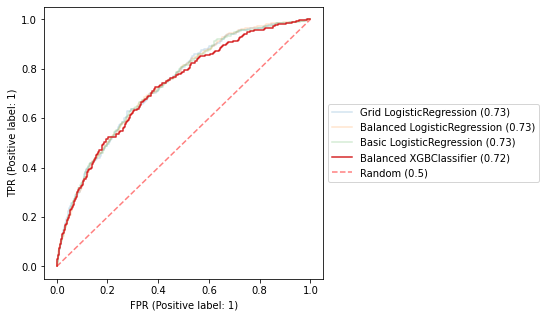

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



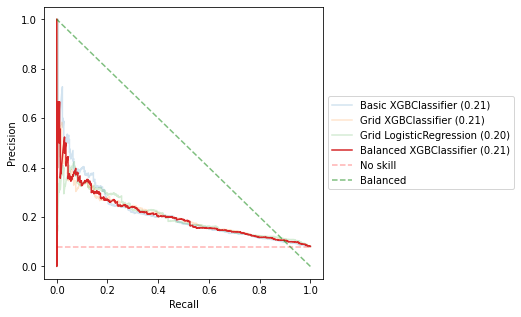

In [124]:
get_scores(model_name, **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [125]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.25616273056369593) for this model is reached with a threshold of 0.47800000000000004


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced XGBClassifier [w/thresholding] --------------------------------------------------------

             ROC_AUC : 0.7240
                  F1 : 0.2342
            ACCURACY : 0.6396
           PRECISION : 0.1411
              RECALL : 0.6889
   AVERAGE_PRECISION : 0.2060

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.64      0.76      4140
Prediction = 1       0.14      0.69      0.23       360

      accuracy                           0.64      4500
     macro avg       0.55      0.66      0.50      4500
  weighted avg       0.89  

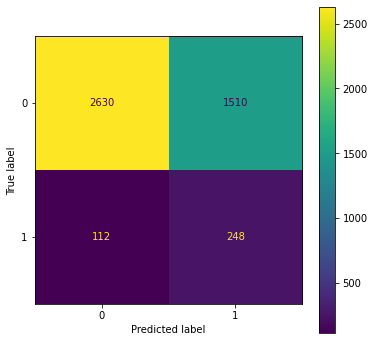

In [126]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 5. Revue des scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [127]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier,None,"{'random_state': [0], 'strategy': ['stratified']}",0.490519,0.078885,0.066578,0.844222,0.063939,0.069444,25,3774,366,335,1.199276,0.002503
1,Basic LogisticRegression,None,"{'random_state': [0], 'max_iter': [3000]}",0.732972,0.199926,0.005464,0.919111,0.166667,0.002778,1,4135,5,359,5.815437,0.040237
2,Basic LogisticRegression [w/thresholding],0.241,"{'random_state': [0], 'max_iter': [3000]}",0.732972,0.199926,0.203866,0.899333,0.277512,0.161111,58,3989,151,302,5.815437,0.003992
3,Basic DecisionTreeClassifier,None,{'random_state': [0]},0.521256,0.084428,0.122449,0.847111,0.113208,0.133333,48,3764,376,312,2.256247,0.013005
4,Basic DecisionTreeClassifier [w/thresholding],0.999,{'random_state': [0]},0.521256,0.084428,0.122449,0.847111,0.113208,0.133333,48,3764,376,312,2.256247,0.009362
5,Basic KNeighborsClassifier,None,{},0.541067,0.088950,0.010309,0.914667,0.071429,0.005556,2,4114,26,358,0.238977,7.527614
6,Basic KNeighborsClassifier [w/thresholding],0.389,{},0.541067,0.088950,0.100840,0.881111,0.127660,0.083333,30,3935,205,330,0.238977,3.542919
7,Basic RandomForestClassifier,None,{'random_state': [0]},0.686125,0.170760,0.000000,0.920000,0.000000,0.000000,0,4140,0,360,2.892661,0.134649
8,Basic RandomForestClassifier [w/thresholding],0.68,{'random_state': [0]},0.686125,0.170760,0.000000,0.920000,0.000000,0.000000,0,4140,0,360,2.892661,0.078468
9,Basic XGBClassifier,None,"{'seed': [0], 'objective': ['binary:logistic']...",0.713682,0.214494,0.111650,0.918667,0.442308,0.063889,23,4111,29,337,8.853084,0.041406


In [128]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Balanced')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
21,Balanced LogisticRegression,0.733060,0.244686,0.655556
23,Balanced DecisionTreeClassifier,0.679716,0.232193,0.575000
25,Balanced RandomForestClassifier,0.707696,0.239642,0.594444
27,Balanced XGBClassifier,0.723996,0.239622,0.633333


In [129]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Balanced')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
22,Balanced LogisticRegression [w/thresholding],0.733060,0.224087,0.741667
24,Balanced DecisionTreeClassifier [w/thresholding],0.679716,0.232193,0.575000
26,Balanced RandomForestClassifier [w/thresholding],0.707696,0.197071,0.822222
28,Balanced XGBClassifier [w/thresholding],0.723996,0.234183,0.688889


In [130]:
sms.send("Balanced done", stop=False)

# Amélioration des modèles avec `SMOT` pour contre balancer le déséquilibrage des classes <a class="anchor" id="models_smot"></a> [⇪](#menu)

In [131]:
from imblearn.over_sampling import SMOTE

In [132]:
#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_x_train, over_y_train = oversample.fit_resample(X_train,y_train)

In [133]:
over_y_train.value_counts()

1    23457
0    23457
Name: TARGET, dtype: int64

In [134]:
y_test.value_counts()

0    4140
1     360
Name: TARGET, dtype: int64

## 1. Logistic Regression balanced with `SMOT` + Grid search<a class="anchor" id="models_linear_smot"></a> [⇪](#menu)

In [135]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [136]:
model_name = "SMOT LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7225
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6938
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6690
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6692
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6697

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6848 (std:0.0298)

----------------------------------------------------------------------------------------------------


In [137]:
grd_log['grid'].best_params_

{'C': 1,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT LogisticRegression ------------------------------------------------------------------------

             ROC_AUC : 0.7188
                  F1 : 0.2295
            ACCURACY : 0.6822
           PRECISION : 0.1424
              RECALL : 0.5917
   AVERAGE_PRECISION : 0.1881

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.69      0.80      4140
Prediction = 1       0.14      0.59      0.23       360

      accuracy                           0.68      4500
     macro avg       0.55      0.64      0.51      4500
  weighted avg       0.89  

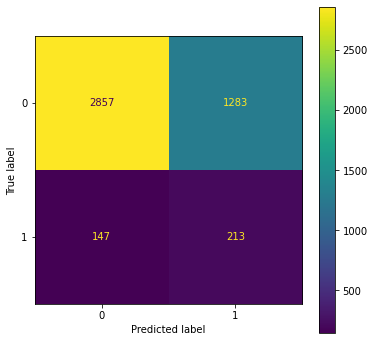

--- ROC AUC ---------------------------------------------------------------------------------------- 



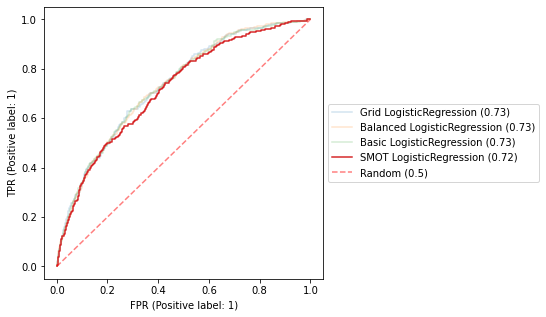

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



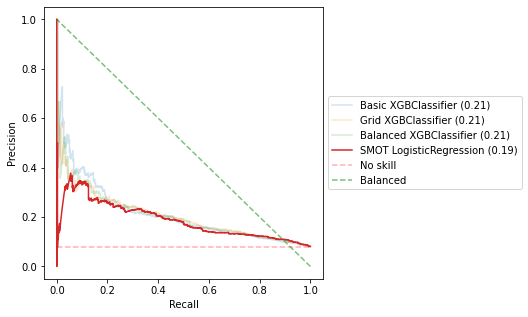

In [138]:
get_scores(model_name, **grd_log, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [139]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.29037778070290904) for this model is reached with a threshold of 0.597


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT LogisticRegression [w/thresholding] -------------------------------------------------------

             ROC_AUC : 0.7188
                  F1 : 0.2630
            ACCURACY : 0.7758
           PRECISION : 0.1784
              RECALL : 0.5000
   AVERAGE_PRECISION : 0.1881

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.80      0.87      4140
Prediction = 1       0.18      0.50      0.26       360

      accuracy                           0.78      4500
     macro avg       0.56      0.65      0.57      4500
  weighted avg       0.89  

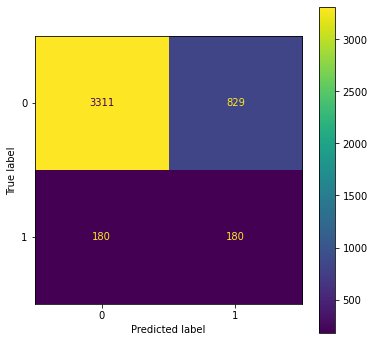

In [140]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 2. Decision Tree balanced with `SMOT` + Grid search <a class="anchor" id="models_decision_tree_smot"></a> [⇪](#menu)

In [141]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [142]:
model_name = "SMOT DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6592
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6804
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6797
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6696
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6852

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6748 (std:0.0360)

----------------------------------------------------------------------------------------------------


In [143]:
grd_dt['grid'].best_params_

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': None,
 'random_state': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT DecisionTreeClassifier --------------------------------------------------------------------

             ROC_AUC : 0.6124
                  F1 : 0.1711
            ACCURACY : 0.7869
           PRECISION : 0.1242
              RECALL : 0.2750
   AVERAGE_PRECISION : 0.1116

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.83      0.88      4140
Prediction = 1       0.12      0.28      0.17       360

      accuracy                           0.79      4500
     macro avg       0.53      0.55      0.52      4500
  weighted avg       0.87  

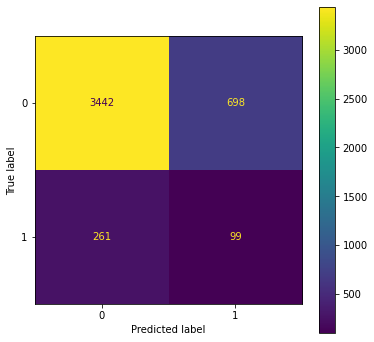

--- ROC AUC ---------------------------------------------------------------------------------------- 



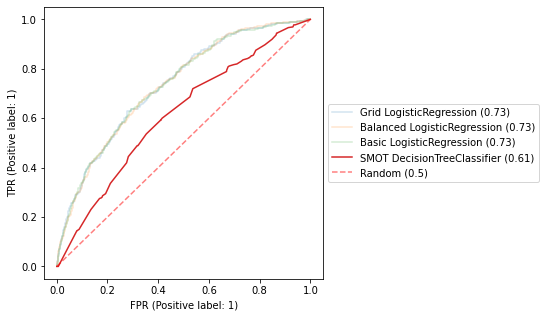

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



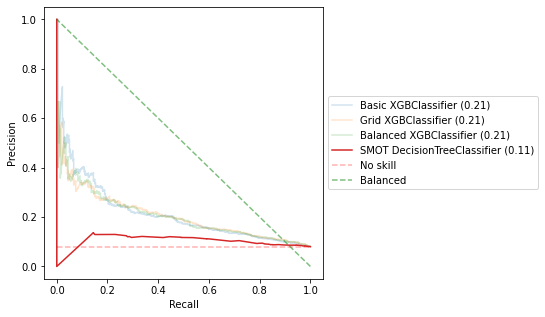

In [144]:
get_scores(model_name, **grd_dt, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [145]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.22065396377322982) for this model is reached with a threshold of 0.23


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT DecisionTreeClassifier [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.6124
                  F1 : 0.1882
            ACCURACY : 0.5858
           PRECISION : 0.1116
              RECALL : 0.6000
   AVERAGE_PRECISION : 0.1116

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.94      0.58      0.72      4140
Prediction = 1       0.11      0.60      0.19       360

      accuracy                           0.59      4500
     macro avg       0.53      0.59      0.46      4500
  weighted avg       0.88  

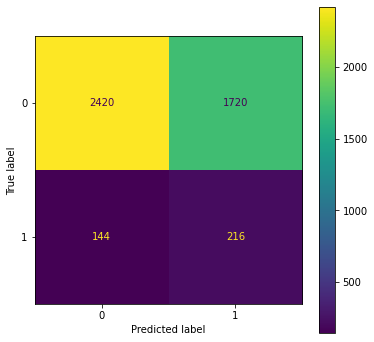

In [146]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 3. KNN *(k-nearest neighbors)* with `SMOT` + Grid search <a class="anchor" id="models_knn_smot"></a> [⇪](#menu)

In [147]:
param_grid = {
    'n_neighbors': list(range(1,35,2)), # tous les chiffres impairs de 1 à 33 inclus
    #'weight_options': ['uniform', 'distance']
}

In [148]:
model_name = "SMOT KNeighborsClassifier"

grd_knn = fit_model(
    model_name,
    KNeighborsClassifier(n_jobs=-1), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6081
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6123
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5687
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6981
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6201

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6215 (std:0.0551)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT KNeighborsClassifier ----------------------------------------------------------------------

             ROC_AUC : 0.5786
                  F1 : 0.1673
            ACCURACY : 0.4933
           PRECISION : 0.0963
              RECALL : 0.6361
   AVERAGE_PRECISION : 0.1005

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.94      0.48      0.64      4140
Prediction = 1       0.10      0.64      0.17       360

      accuracy                           0.49      4500
     macro avg       0.52      0.56      0.40      4500
  weighted avg       0.87  

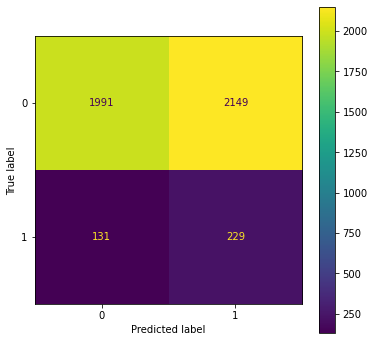

--- ROC AUC ---------------------------------------------------------------------------------------- 



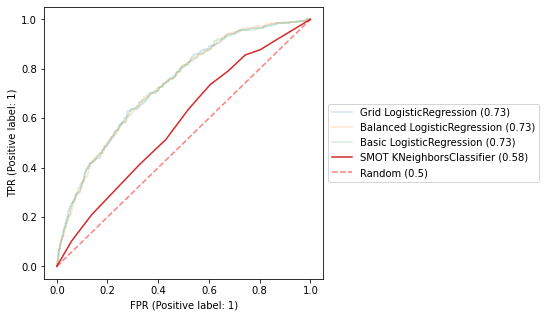

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



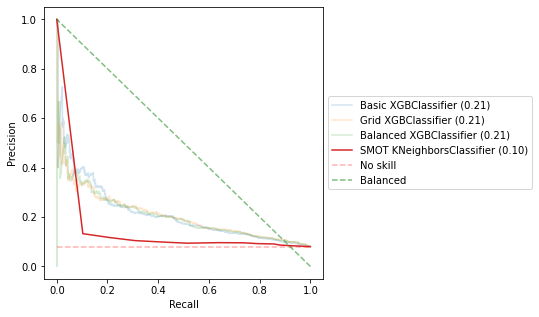

In [149]:
get_scores(model_name, **grd_knn, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [150]:
f1_value, best_threshold = find_best_threshold(grd_knn['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.8857376602127078) for this model is reached with a threshold of 0.91


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT KNeighborsClassifier [w/thresholding] -----------------------------------------------------

             ROC_AUC : 0.5786
                  F1 : 0.1158
            ACCURACY : 0.8744
           PRECISION : 0.1326
              RECALL : 0.1028
   AVERAGE_PRECISION : 0.1005

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.94      0.93      4140
Prediction = 1       0.13      0.10      0.12       360

      accuracy                           0.87      4500
     macro avg       0.53      0.52      0.52      4500
  weighted avg       0.86  

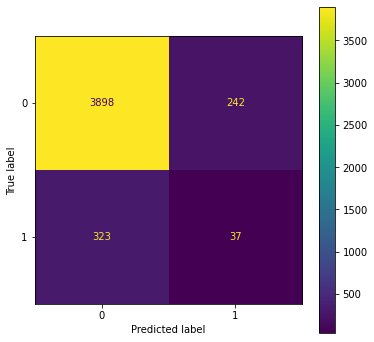

In [151]:
get_scores(f"{model_name} [w/thresholding]", **grd_knn, threshold=best_threshold, register=True, show_roccurves=False)

## 4. Random Forest balanced with `SMOT` + Grid search<a class="anchor" id="models_random_forest_smot"></a> [⇪](#menu)

In [152]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 528]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [153]:
model_name = "SMOT RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.8758
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.9049
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.8452
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.8525
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.9158

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.8789 (std:0.0318)

----------------------------------------------------------------------------------------------------


In [154]:
grd_rf['grid'].best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'n_estimators': 500,
 'random_state': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT RandomForestClassifier --------------------------------------------------------------------

             ROC_AUC : 0.6866
                  F1 : 0.0319
            ACCURACY : 0.9191
           PRECISION : 0.3750
              RECALL : 0.0167
   AVERAGE_PRECISION : 0.1599

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.38      0.02      0.03       360

      accuracy                           0.92      4500
     macro avg       0.65      0.51      0.49      4500
  weighted avg       0.88  

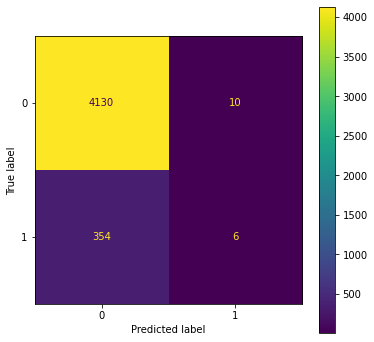

--- ROC AUC ---------------------------------------------------------------------------------------- 



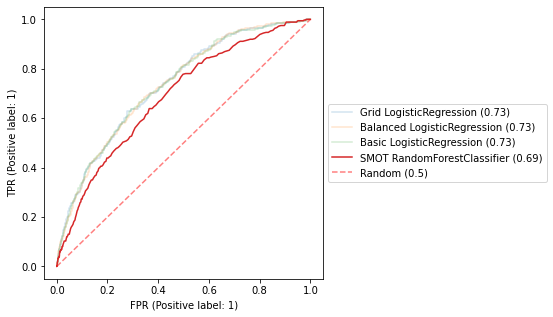

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



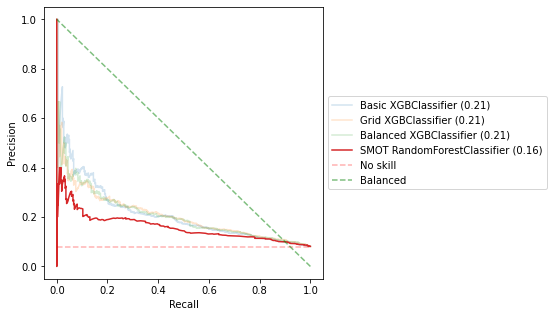

In [155]:
get_scores(model_name, **grd_rf, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [156]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.7777445408315884) for this model is reached with a threshold of 0.776


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT RandomForestClassifier [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.6866
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1599

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

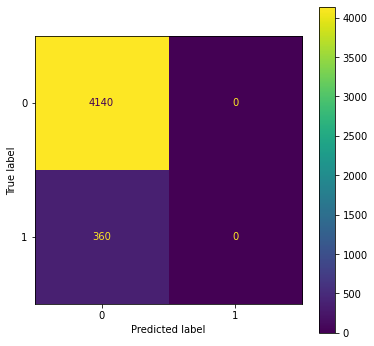

In [157]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 5. XGBoost Classifier balanced with `SMOT` + Grid search<a class="anchor" id="models_xgboost_smot"></a> [⇪](#menu)

In [158]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [159]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [160]:
model_name = "SMOT XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.8840
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.8882
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.8700
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.9139
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.8813

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.8875 (std:0.0205)

----------------------------------------------------------------------------------------------------


In [161]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.1,
 'max_depth': 8,
 'n_estimators': 140,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.481644640234949,
 'seed': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT XGBClassifier -----------------------------------------------------------------------------

             ROC_AUC : 0.6629
                  F1 : 0.2303
            ACCURACY : 0.8202
           PRECISION : 0.1751
              RECALL : 0.3361
   AVERAGE_PRECISION : 0.1648

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.94      0.86      0.90      4140
Prediction = 1       0.18      0.34      0.23       360

      accuracy                           0.82      4500
     macro avg       0.56      0.60      0.56      4500
  weighted avg       0.88  

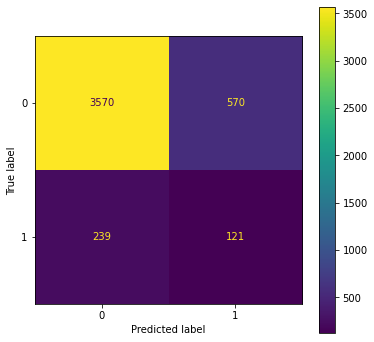

--- ROC AUC ---------------------------------------------------------------------------------------- 



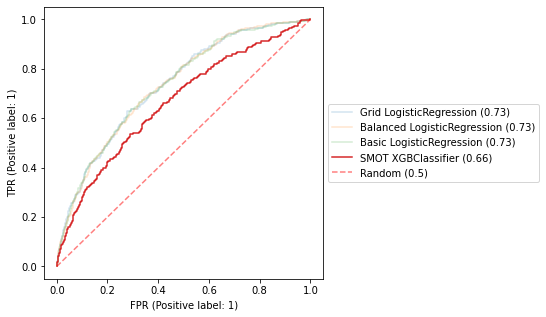

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



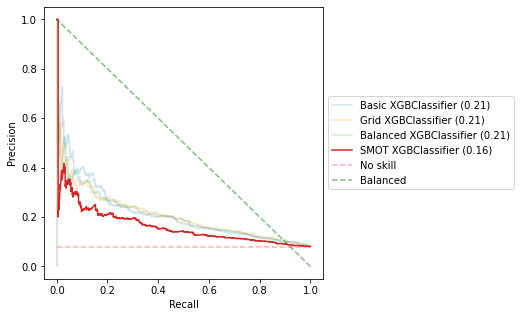

In [162]:
get_scores(model_name, **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [163]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.8176454060129249) for this model is reached with a threshold of 0.8160000000000001


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT XGBClassifier [w/thresholding] ------------------------------------------------------------

             ROC_AUC : 0.6629
                  F1 : 0.0874
            ACCURACY : 0.9164
           PRECISION : 0.3462
              RECALL : 0.0500
   AVERAGE_PRECISION : 0.1648

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      4140
Prediction = 1       0.35      0.05      0.09       360

      accuracy                           0.92      4500
     macro avg       0.63      0.52      0.52      4500
  weighted avg       0.88  

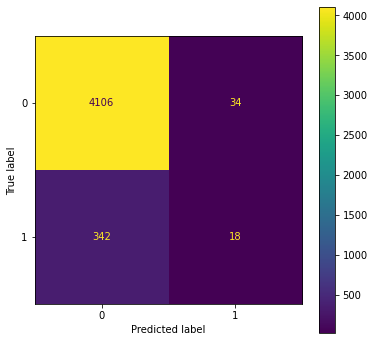

In [164]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 6. Revue des scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [165]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier,None,"{'random_state': [0], 'strategy': ['stratified']}",0.490519,0.078885,0.066578,0.844222,0.063939,0.069444,25,3774,366,335,1.199276,0.002503
1,Basic LogisticRegression,None,"{'random_state': [0], 'max_iter': [3000]}",0.732972,0.199926,0.005464,0.919111,0.166667,0.002778,1,4135,5,359,5.815437,0.040237
2,Basic LogisticRegression [w/thresholding],0.241,"{'random_state': [0], 'max_iter': [3000]}",0.732972,0.199926,0.203866,0.899333,0.277512,0.161111,58,3989,151,302,5.815437,0.003992
3,Basic DecisionTreeClassifier,None,{'random_state': [0]},0.521256,0.084428,0.122449,0.847111,0.113208,0.133333,48,3764,376,312,2.256247,0.013005
4,Basic DecisionTreeClassifier [w/thresholding],0.999,{'random_state': [0]},0.521256,0.084428,0.122449,0.847111,0.113208,0.133333,48,3764,376,312,2.256247,0.009362
5,Basic KNeighborsClassifier,None,{},0.541067,0.088950,0.010309,0.914667,0.071429,0.005556,2,4114,26,358,0.238977,7.527614
6,Basic KNeighborsClassifier [w/thresholding],0.389,{},0.541067,0.088950,0.100840,0.881111,0.127660,0.083333,30,3935,205,330,0.238977,3.542919
7,Basic RandomForestClassifier,None,{'random_state': [0]},0.686125,0.170760,0.000000,0.920000,0.000000,0.000000,0,4140,0,360,2.892661,0.134649
8,Basic RandomForestClassifier [w/thresholding],0.68,{'random_state': [0]},0.686125,0.170760,0.000000,0.920000,0.000000,0.000000,0,4140,0,360,2.892661,0.078468
9,Basic XGBClassifier,None,"{'seed': [0], 'objective': ['binary:logistic']...",0.713682,0.214494,0.111650,0.918667,0.442308,0.063889,23,4111,29,337,8.853084,0.041406


In [166]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('SMOT')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
29,SMOT LogisticRegression,0.718763,0.229526,0.591667
31,SMOT DecisionTreeClassifier,0.612362,0.171132,0.275000
33,SMOT KNeighborsClassifier,0.578591,0.167275,0.636111
35,SMOT RandomForestClassifier,0.686561,0.031915,0.016667
37,SMOT XGBClassifier,0.662884,0.230257,0.336111


In [167]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('SMOT')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
30,SMOT LogisticRegression [w/thresholding],0.718763,0.262966,0.500000
32,SMOT DecisionTreeClassifier [w/thresholding],0.612362,0.188153,0.600000
34,SMOT KNeighborsClassifier [w/thresholding],0.578591,0.115806,0.102778
36,SMOT RandomForestClassifier [w/thresholding],0.686561,0.000000,0.000000
38,SMOT XGBClassifier [w/thresholding],0.662884,0.087379,0.050000


# Amélioration des modèles avec de `nouvelles features` <a class="anchor" id="models_feature_engineering"></a> [⇪](#menu)

In [168]:
data_application_full = pd.read_csv(
    zip_file.open('application_train.csv'),
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

data_application_full.shape

(307511, 122)

## 0. Création des nouvelles features *(Feature Engineering)* <a class="anchor" id="feature_engineering"></a> [⇪](#menu)

#### Quelle fraction du bien convointé représente le montant du crédit ?

In [169]:
data_application_full['FRAC_GOODS_PRICE'] = data_application_full.AMT_CREDIT / data_application_full.AMT_GOODS_PRICE

In [170]:
data_application_full[['AMT_CREDIT','AMT_GOODS_PRICE','FRAC_GOODS_PRICE']].head()

,AMT_CREDIT,AMT_GOODS_PRICE,FRAC_GOODS_PRICE
0,406597.5,351000.0,1.158397
1,1293502.5,1129500.0,1.145199
2,135000.0,135000.0,1.000000
3,312682.5,297000.0,1.052803
4,513000.0,513000.0,1.000000


#### Quel age (en années) avait le client quand il a obtenu son emploi actuel ?

In [171]:
data_application_full['AGE_EMPLOYEMENT'] = (data_application_full.DAYS_BIRTH - data_application_full.DAYS_EMPLOYED) / -365

In [172]:
data_application_full[['DAYS_BIRTH','DAYS_EMPLOYED','AGE_EMPLOYEMENT']].head()

,DAYS_BIRTH,DAYS_EMPLOYED,AGE_EMPLOYEMENT
0,-9461,-637,24.175342
1,-16765,-1188,42.676712
2,-19046,-225,51.564384
3,-19005,-3039,43.742466
4,-19932,-3038,46.284932


#### Quel montant de revenu est disponible pour chaque membre de la famille ?

In [173]:
data_application_full['INCOME_PER_FAM_MEMBER'] = data_application_full.AMT_INCOME_TOTAL / data_application_full.CNT_FAM_MEMBERS

In [174]:
data_application_full[['AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','INCOME_PER_FAM_MEMBER']].head()

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,INCOME_PER_FAM_MEMBER
0,202500.0,1.0,202500.0
1,270000.0,2.0,135000.0
2,67500.0,1.0,67500.0
3,135000.0,2.0,67500.0
4,121500.0,1.0,121500.0


#### Combien de demandes de crédits ont été faites au total ?

In [175]:
data_application_full['AMT_REQ_CREDIT_BUREAU_TOTAL'] =  data_application_full.AMT_REQ_CREDIT_BUREAU_HOUR +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_DAY +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_WEEK +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_MON +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_QRT +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_YEAR

In [176]:
data_application_full[['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','AMT_REQ_CREDIT_BUREAU_TOTAL']].head()

,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_TOTAL
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Ajoutons les nouvelles features au jeu de données

In [177]:
data_application_train2 = data_application_train.copy()

In [178]:
data_application_train2['FRAC_GOODS_PRICE'] = data_application_full['FRAC_GOODS_PRICE']
data_application_train2['AGE_EMPLOYEMENT'] = data_application_full['AGE_EMPLOYEMENT']
data_application_train2['INCOME_PER_FAM_MEMBER'] = data_application_full['INCOME_PER_FAM_MEMBER']
data_application_train2['AMT_REQ_CREDIT_BUREAU_TOTAL'] = data_application_full['AMT_REQ_CREDIT_BUREAU_TOTAL']

#### Vérifions la corrélation linéaire des nouvelles variables avec TARGET

In [179]:
correlations = data_application_train2.corr(method='pearson')

In [180]:
view_size = 100
threshold = 0.0
corr_target = correlations.TARGET.sort_values(ascending=False)
print(f"{f'TOP POSITIVES > {threshold}'.rjust(40)}          {f'TOP NEGATIVES < -{threshold}'.rjust(40)}\n{'-'*100}")
for i, row in enumerate(zip(
    corr_target.head(view_size).index, corr_target.head(view_size), 
    reversed(corr_target.tail(view_size).index), reversed(corr_target.tail(view_size)))):
    
    if row[0] in ['FRAC_GOODS_PRICE', 'AGE_EMPLOYEMENT', 'INCOME_PER_FAM_MEMBER', 'AMT_REQ_CREDIT_BUREAU_TOTAL']:
        print(f"{row[0].rjust(40)} : {row[1]:6.4f} {row[2].rjust(40)} : {row[3]:6.4f}")

                     TOP POSITIVES > 0.0                              TOP NEGATIVES < -0.0
----------------------------------------------------------------------------------------------------
                        FRAC_GOODS_PRICE : 0.0694                             EXT_SOURCE_1 : -0.1553
             AMT_REQ_CREDIT_BUREAU_TOTAL : 0.0108                          LIVINGAREA_MODE : -0.0307
                   INCOME_PER_FAM_MEMBER : -0.0066                            LANDAREA_MODE : -0.0102


### Préparons le jeu de données incluant les nouvelles colonnes

In [181]:
data_clean = data_application_train2[:sample_size_base].copy()

#### Séparation en train et test sets

In [182]:
X_full = data_clean.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_clean['TARGET']

In [183]:
X_train, X_test, y_train, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.15,
                                                random_state=0,
                                                stratify=Y_full)

In [184]:
print(f"X_train: {X_train.shape[0] / X_full.shape[0] * 100}% | X_test: {X_test.shape[0] / X_full.shape[0]* 100}%")

X_train: 85.0% | X_test: 15.0%


#### Encodage des données non-numériques

In [185]:
oe_model, ohe_model = fit_labels(X_train)

In [186]:
X_train = transform_labels(X_train, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)

#### Imputations des données manquantes

In [187]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

In [188]:
X_train = impute(X_train, imputer_model)
X_test = impute(X_test, imputer_model)

(25500, 242) <class 'pandas.core.frame.DataFrame'>
(4500, 242) <class 'pandas.core.frame.DataFrame'>


#### Normalisation du jeu de données

In [189]:
model_scaler = fit_normalizer(X_train)

In [190]:
X_train = normalize(X_train, model_scaler)
X_test = normalize(X_test, model_scaler)

## 1. Balanced Logistic Regression Grid + extra features<a class="anchor" id="models_linear_balanced_feature"></a> [⇪](#menu)

In [191]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [192]:
model_name = "Balanced LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5588
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6385
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6072
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6250
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5865

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6032 (std:0.0508)

----------------------------------------------------------------------------------------------------


In [193]:
grd_log['grid'].best_params_

{'C': 1,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced LogisticRegression [w/features] -------------------------------------------------------

             ROC_AUC : 0.7304
                  F1 : 0.2380
            ACCURACY : 0.6742
           PRECISION : 0.1464
              RECALL : 0.6361
   AVERAGE_PRECISION : 0.2002

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.64      0.24       360

      accuracy                           0.67      4500
     macro avg       0.55      0.66      0.52      4500
  weighted avg       0.89  

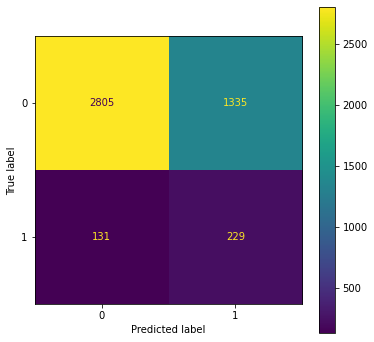

--- ROC AUC ---------------------------------------------------------------------------------------- 



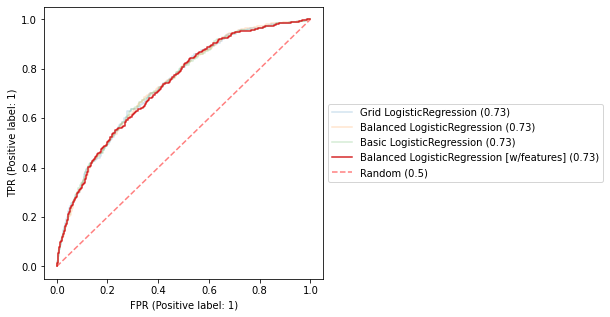

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



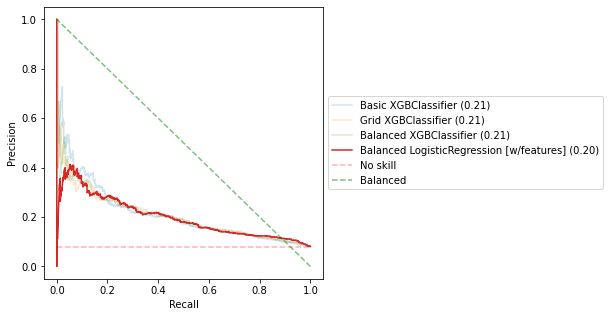

In [194]:
get_scores(f"{model_name} [w/features]", **grd_log, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [195]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2893586005830904) for this model is reached with a threshold of 0.5710000000000001


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced LogisticRegression [w/thresholding & features] ----------------------------------------

             ROC_AUC : 0.7304
                  F1 : 0.2603
            ACCURACY : 0.7487
           PRECISION : 0.1702
              RECALL : 0.5528
   AVERAGE_PRECISION : 0.2002

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.77      0.85      4140
Prediction = 1       0.17      0.55      0.26       360

      accuracy                           0.75      4500
     macro avg       0.56      0.66      0.55      4500
  weighted avg       0.89  

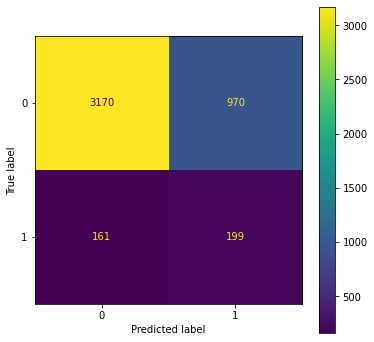

In [196]:
get_scores(f"{model_name} [w/thresholding & features]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 2. Balanced Decision Tree Grid + extra features<a class="anchor" id="models_decision_tree_balanced_feature"></a> [⇪](#menu)

In [197]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [198]:
model_name = "Balanced DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5615
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5511
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5105
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5796
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6156

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5637 (std:0.0559)

----------------------------------------------------------------------------------------------------


In [199]:
grd_dt['grid'].best_params_

{'ccp_alpha': 0.001,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'random_state': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced DecisionTreeClassifier [w/features] ---------------------------------------------------

             ROC_AUC : 0.6801
                  F1 : 0.2322
            ACCURACY : 0.6958
           PRECISION : 0.1455
              RECALL : 0.5750
   AVERAGE_PRECISION : 0.1417

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.71      0.81      4140
Prediction = 1       0.15      0.57      0.23       360

      accuracy                           0.70      4500
     macro avg       0.55      0.64      0.52      4500
  weighted avg       0.89  

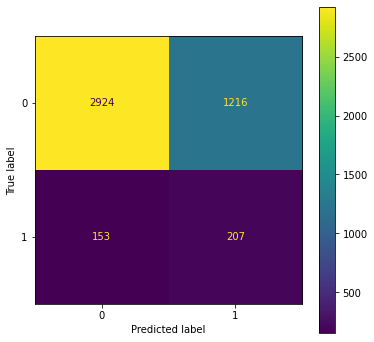

--- ROC AUC ---------------------------------------------------------------------------------------- 



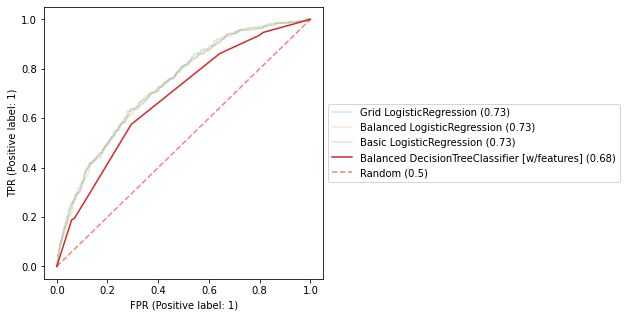

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



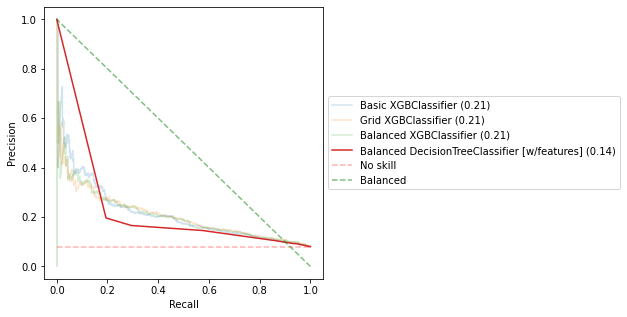

In [200]:
get_scores(f"{model_name} [w/features]", **grd_dt, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [201]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.185929648241206) for this model is reached with a threshold of 0.379


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced DecisionTreeClassifier [w/thresholding & features] ------------------------------------

             ROC_AUC : 0.6801
                  F1 : 0.1863
            ACCURACY : 0.3982
           PRECISION : 0.1044
              RECALL : 0.8611
   AVERAGE_PRECISION : 0.1417

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.36      0.52      4140
Prediction = 1       0.10      0.86      0.19       360

      accuracy                           0.40      4500
     macro avg       0.54      0.61      0.35      4500
  weighted avg       0.90  

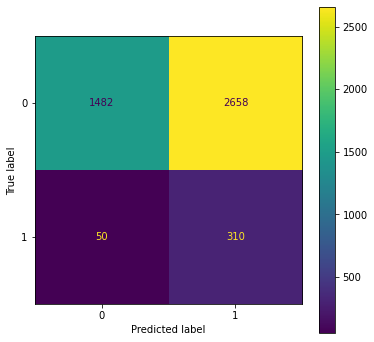

In [202]:
get_scores(f"{model_name} [w/thresholding & features]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Balanced Random Forest Grid + extra features <a class="anchor" id="models_random_forest_balanced_feature"></a> [⇪](#menu)

In [203]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 528]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [204]:
model_name = "Balanced RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6616
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5927
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6520
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5790
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7477

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6466 (std:0.0746)

----------------------------------------------------------------------------------------------------


In [205]:
grd_rf['grid'].best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'n_estimators': 200,
 'random_state': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced RandomForestClassifier [w/features] ---------------------------------------------------

             ROC_AUC : 0.7114
                  F1 : 0.2536
            ACCURACY : 0.7082
           PRECISION : 0.1594
              RECALL : 0.6194
   AVERAGE_PRECISION : 0.1998

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.72      0.82      4140
Prediction = 1       0.16      0.62      0.25       360

      accuracy                           0.71      4500
     macro avg       0.56      0.67      0.54      4500
  weighted avg       0.89  

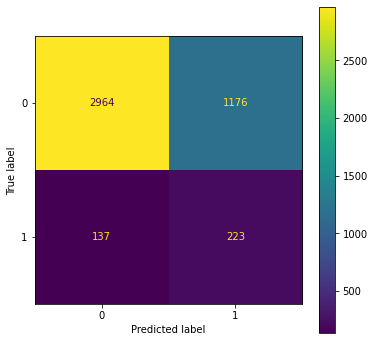

--- ROC AUC ---------------------------------------------------------------------------------------- 



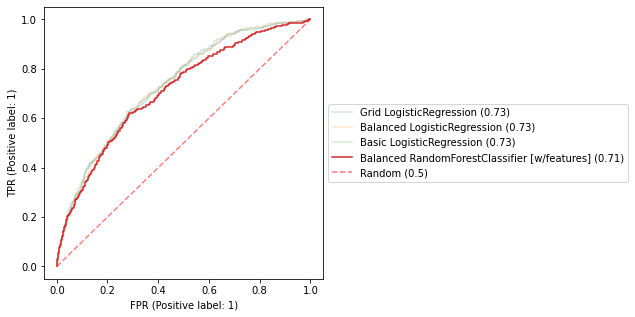

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



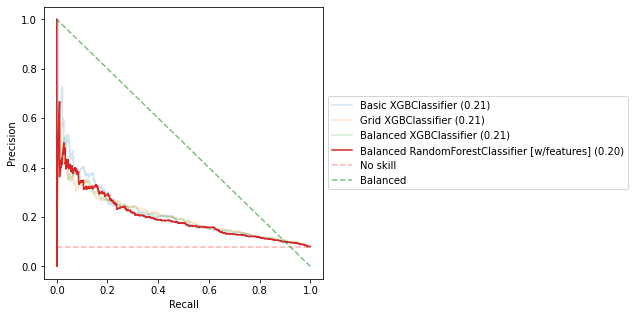

In [206]:
get_scores(f"{model_name} [w/features]", **grd_rf, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [207]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2141423680793295) for this model is reached with a threshold of 0.378


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced RandomForestClassifier [w/thresholding & features] ------------------------------------

             ROC_AUC : 0.7114
                  F1 : 0.1970
            ACCURACY : 0.4582
           PRECISION : 0.1117
              RECALL : 0.8306
   AVERAGE_PRECISION : 0.1998

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.43      0.59      4140
Prediction = 1       0.11      0.83      0.20       360

      accuracy                           0.46      4500
     macro avg       0.54      0.63      0.39      4500
  weighted avg       0.90  

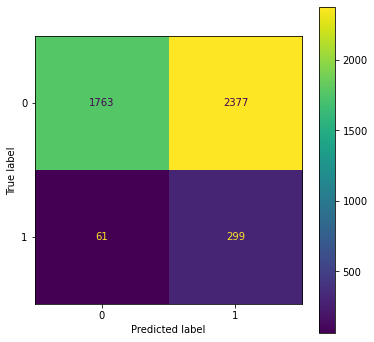

In [208]:
get_scores(f"{model_name} [w/thresholding & features]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 4. Balanced XGBoost Classifier Grid + extra features<a class="anchor" id="models_xgboost_balanced_feature"></a> [⇪](#menu)

In [209]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [210]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [211]:
model_name = "Balanced XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.4990
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7043
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6468
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7043
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5430

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6195 (std:0.0927)

----------------------------------------------------------------------------------------------------


In [212]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 60,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.481644640234949,
 'seed': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced XGBClassifier [w/features] ------------------------------------------------------------

             ROC_AUC : 0.7220
                  F1 : 0.2403
            ACCURACY : 0.6727
           PRECISION : 0.1476
              RECALL : 0.6472
   AVERAGE_PRECISION : 0.2057

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.67      0.79      4140
Prediction = 1       0.15      0.65      0.24       360

      accuracy                           0.67      4500
     macro avg       0.55      0.66      0.52      4500
  weighted avg       0.89  

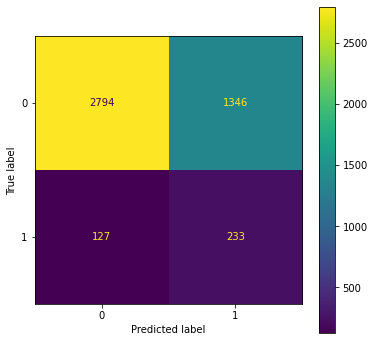

--- ROC AUC ---------------------------------------------------------------------------------------- 



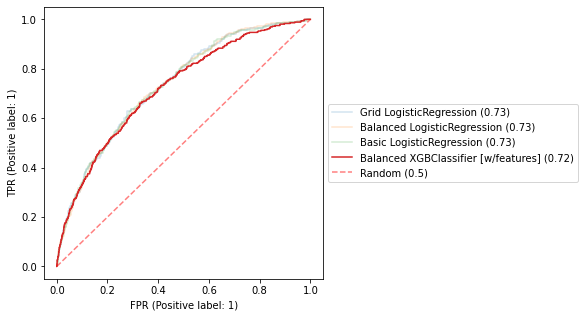

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



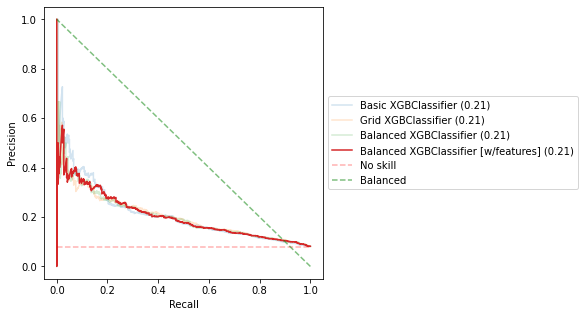

In [213]:
get_scores(f"{model_name} [w/features]", **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [214]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.29159303206261045) for this model is reached with a threshold of 0.558


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced XGBClassifier [w/thresholding & features] ---------------------------------------------

             ROC_AUC : 0.7220
                  F1 : 0.2591
            ACCURACY : 0.7598
           PRECISION : 0.1720
              RECALL : 0.5250
   AVERAGE_PRECISION : 0.2057

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.78      0.86      4140
Prediction = 1       0.17      0.53      0.26       360

      accuracy                           0.76      4500
     macro avg       0.56      0.65      0.56      4500
  weighted avg       0.89  

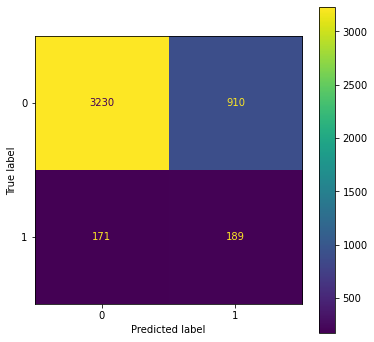

In [215]:
get_scores(f"{model_name} [w/thresholding & features]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 5. Revue des scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [216]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier,None,"{'random_state': [0], 'strategy': ['stratified']}",0.490519,0.078885,0.066578,0.844222,0.063939,0.069444,25,3774,366,335,1.199276,0.002503
1,Basic LogisticRegression,None,"{'random_state': [0], 'max_iter': [3000]}",0.732972,0.199926,0.005464,0.919111,0.166667,0.002778,1,4135,5,359,5.815437,0.040237
2,Basic LogisticRegression [w/thresholding],0.241,"{'random_state': [0], 'max_iter': [3000]}",0.732972,0.199926,0.203866,0.899333,0.277512,0.161111,58,3989,151,302,5.815437,0.003992
3,Basic DecisionTreeClassifier,None,{'random_state': [0]},0.521256,0.084428,0.122449,0.847111,0.113208,0.133333,48,3764,376,312,2.256247,0.013005
4,Basic DecisionTreeClassifier [w/thresholding],0.999,{'random_state': [0]},0.521256,0.084428,0.122449,0.847111,0.113208,0.133333,48,3764,376,312,2.256247,0.009362
5,Basic KNeighborsClassifier,None,{},0.541067,0.088950,0.010309,0.914667,0.071429,0.005556,2,4114,26,358,0.238977,7.527614
6,Basic KNeighborsClassifier [w/thresholding],0.389,{},0.541067,0.088950,0.100840,0.881111,0.127660,0.083333,30,3935,205,330,0.238977,3.542919
7,Basic RandomForestClassifier,None,{'random_state': [0]},0.686125,0.170760,0.000000,0.920000,0.000000,0.000000,0,4140,0,360,2.892661,0.134649
8,Basic RandomForestClassifier [w/thresholding],0.68,{'random_state': [0]},0.686125,0.170760,0.000000,0.920000,0.000000,0.000000,0,4140,0,360,2.892661,0.078468
9,Basic XGBClassifier,None,"{'seed': [0], 'objective': ['binary:logistic']...",0.713682,0.214494,0.111650,0.918667,0.442308,0.063889,23,4111,29,337,8.853084,0.041406


In [217]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
39,Balanced LogisticRegression [w/features],0.730449,0.238046,0.636111
41,Balanced DecisionTreeClassifier [w/features],0.680082,0.232193,0.575000
43,Balanced RandomForestClassifier [w/features],0.711427,0.253553,0.619444
45,Balanced XGBClassifier [w/features],0.722035,0.240330,0.647222


In [218]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
40,Balanced LogisticRegression [w/thresholding & ...,0.730449,0.260301,0.552778
42,Balanced DecisionTreeClassifier [w/thresholdin...,0.680082,0.186298,0.861111
44,Balanced RandomForestClassifier [w/thresholdin...,0.711427,0.196970,0.830556
46,Balanced XGBClassifier [w/thresholding & featu...,0.722035,0.259082,0.525000


In [219]:
sms.send()

JupyterScriptCompleted: Jupyter is waiting

# Custom metric <a class="anchor" id="custom_metric"></a> [⇪](#menu)

## 1. The problem <a class="anchor" id="custom_metric_problem"></a> [⇪](#menu)

>#### Let's interpret the four correlation matrix values in regards to this project:
> - `(TP) True Positive` : the client is predicted as NOT OK and it really is NOT OK. *(we **save** money)*
> - `(TN) True Negative` : the client is predicted as OK and it really is OK. *(we **earn** money)*
> - `(FP) False Positive` : the client is predicted as OK but it is in fact NOT OK. *(we **miss** money)*
> - `(FN) False Negative` : the client is predicted as NOT OK but it is in fact OK. *(we **lose** money)*
>
>#### So the goals in order of importance are:
> 1. minimize the `(FN) False Negative` to **avoid losing money**.
> 2. maximize the `(TN) True Negative` to **earn money**.
> 3. maximize the `(TP) True Positive` to save money.
> 4. minimize the `(FP) False Positive` to avoid missing money.

>#### Currently we are using the F1-measure and the ROC-AUC score.
>
> - The `F1-Measure` **balance the weight** on PRECISION and RECALL.
> - The `ROC AUC score`  summarize the **trade-off** between the true positive rate (RECALL) and false positive rate (ANTI-SPECIFICITY).
>

> RECALL = $\frac{TP}{TP + FN}$
> - High RECALL favors TP over FN
> - Low RECALL favors FN over TP

> PRECISION = $\frac{TP}{TP + FP}$
> - High PRECISION favors TP over FP
> - Low PRECISION favors FP over TP

> ANTI-SPECIFICITY = 1 - SPECIFICITY = 1 - $\frac{TN}{TN + FS}$ = $\frac{FP}{FP + TN}$
> - High ANTI-SPECIFICITY favors FP over TN
> - Low ANTI-SPECIFICITY favors TN over FP

## 2. F-measure <a class="anchor" id="custom_metric_solution"></a> [⇪](#menu)

> * `F0.5-Measure`: **More weight on precision**, less weight on recall.
> * `F1-Measure`  : **Balance the weight** on precision and recall.
> * `F2-Measure`  : **More weight on recall**, less weight on precision.

>#### And luckily, there exists a [Fbeta-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) function in sklearn, which can be used to reproduce those F-measure and any in between measure... So we can in fact decide how much weight we want to give to RECALL.

>#### We want to maximize this `Fbeta-score` with beta > 1.0 !

In [ ]:
from sklearn.metrics import fbeta_score
fb_score = fbeta_score(y_test, y_pred_log, beta=2.0)
fb_score

In [ ]:
import FreeMobileSMS as sms
sms.send()

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
def my_loss(xvals, yvals, validation=False):
    print(xvals.index, yvals, validation)
    return 1.0

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
grd_dt = fit_model(
    DecisionTreeClassifier(), 
    param_grid={ 'random_state':[0] }, 
    cv = skfold,
    scoring="custom"
)

In [ ]:
get_scores(f"Basic {get_model_name(grd_dt['model'])}", **grd_dt, register=True)